In [1]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\mohan\env\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

In [3]:
from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])
class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal
        
        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):
                        
                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)
      
    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):
            
            p += self.P[state, next_state, action]
            
            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          if next_next in self.goal_states_seq:
                done=True 
          else:
                done=False
          return next_next, self.R[next_next],done
        else:
          if next_state in self.goal_states_seq:
                done=True 
          else:
            done=False
          return next_state, self.R[next_state],done


In [4]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()
def print_grid_world():
  print_grid=np.zeros((num_cols,num_rows))
  for i in obstructions:
    print_grid[i[0]][i[1]]=-1 
  for i in start_state:
    print_grid[i[0]][i[1]]=1 
  for i in bad_states:
    print_grid[i[0]][i[1]]=-2 
  for i in restart_states:
    print_grid[i[0]][i[1]]=2 
  for i in goal_states:
    print_grid[i[0]][i[1]]=3 
  print(print_grid)

In [5]:
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
actions = [UP,DOWN,LEFT,RIGHT]


# FUNCTIONS FOR THE 3 PLOTS

In [6]:
def plot_Q(Q, message = "Q plot",progress=""):
    k=len(message)
    plt.figure(figsize=(10,10))
    plt.suptitle(message[:k//2]+"\n"+message[k//2:])
    print(message[:k//2]+"\n"+message[k//2])
    plt.title(progress)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    def x_direct(a):
        if a in [UP, DOWN]:
            return 0
        return 1 if a == RIGHT else -1
    def y_direct(a):
        if a in [RIGHT, LEFT]:
            return 0
        return 1 if a == DOWN else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.savefig(f"Q_{message}.jpg")
    
def plot_state_visits(state_visit_counts,message="State Visit Count Plot",progress=""):
    k=len(message)
    plt.figure(figsize=(10,10))
    
    plt.suptitle(message[:k//2]+"\n"+message[k//2:])
    plt.title(progress)
    plt.pcolor(state_visit_counts, edgecolors='k', linewidths=2)
    plt.colorbar()
    plt.savefig(f"State_{message}.jpg")
    

def plot_rewards_steps(avg_steps,avg_rewards,message_st="Plot for Avg steps to episodes", message_re="Plot for Avg rewards"):   
    k1=len(message_st)
    plt.figure(figsize=(10,10))
    plt.xlabel('Episode')
    plt.ylabel('Number of steps to Goal')
    plt.plot([i+1 for i in range(len(avg_steps))],avg_steps)
    plt.title(message_st[:k1//2]+"\n"+message_st[k1//2:])
    plt.savefig(f"{message_st}.jpg")

    plt.figure(figsize=(10,10))
    k2=len(message_re)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.plot([i+1 for i in range(len(avg_rewards))],avg_rewards)
    plt.title(message_re[:k2//2]+"\n"+message_re[k2//2:])
    plt.savefig(f"{message_re}.jpg")

    


# EPSILON AND SOFTMAX POLICIES

In [7]:
from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)

# Epsilon greedy
def choose_action_epsilon(Q, state, epsilon=0.4, rg=rg):
    if rg.rand()<epsilon: # TODO: eps greedy condition
        return rg.randint(len(actions))# TODO: return random action
    else:
        return np.argmax(Q[state[0]][state[1]])# TODO: return best action

# Softmax
def choose_action_softmax(Q, state,tau=10,rg=rg):
    
    probs=softmax(Q[state[0]][state[1]]/tau)
    return actions.index(rg.choice(actions,p=probs)) 
    

In [8]:
Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))

alpha = 0.4
beta=0.1 
gamma = 0.9
episodes = 2000
epsilon0 = 0.1

# SARSA

In [9]:
print_freq = 100

def sarsa(env, Q,alpha=0.4, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax,choose_action_parameter=0):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        state_visit_count=np.zeros((env.num_rows, env.num_cols))
        state = seq_to_col_row(env.reset(),num_cols)
        action = choose_action(Q, state[0],choose_action_parameter)
      
        done = False
        timesteps=0 
        
        
        while not done and timesteps<100:
            state_visit_count[state[0][0]][state[0][1]]+=1
            
            state_next, reward,done = env.step(row_col_to_seq(state,num_cols),action)
            
            state_next=(seq_to_col_row(state_next,num_cols))
            reward=reward[0]
            action_next = choose_action(Q, state_next[0],choose_action_parameter)
            
            # TODO: update equation
            Q[state[0][0]][state[0][1]][action]=Q[state[0][0]][state[0][1]][action]+alpha*(reward+gamma*(Q[state_next[0][0]][state_next[0][1]][action_next])-Q[state[0][0]][state[0][1]][action])
                                                    
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next
            timesteps+=1
            state_visit_count[state[0][0]][state[0][1]]+=1
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
    
        
        
    return Q, episode_rewards, steps_to_completion, state_visit_count

In [10]:
file = open('items.txt','w')

# Q-Learning

In [11]:
def qlearning(env, Q,alpha=0.4, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax,choose_action_parameter=0):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        state_visit_count=np.zeros((env.num_rows, env.num_cols))
        state = seq_to_col_row(env.reset(),num_cols)
        action = choose_action(Q, state[0],choose_action_parameter)
      
        done = False
        timesteps=0 
        
        
        while not done and timesteps<100:
            state_visit_count[state[0][0]][state[0][1]]+=1
            
            state_next, reward,done = env.step(row_col_to_seq(state,num_cols),action)
            
            state_next=(seq_to_col_row(state_next,num_cols))
            reward=reward[0]
            action_next = choose_action(Q, state_next[0],choose_action_parameter)
            
            # TODO: update equation
            
            Q[state[0][0]][state[0][1]][action]=Q[state[0][0]][state[0][1]][action]+alpha*(reward+gamma*(np.max(Q[state_next[0][0]][state_next[0][1]]))-Q[state[0][0]][state[0][1]][action])
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next
            timesteps+=1
            state_visit_count[state[0][0]][state[0][1]]+=1
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
                
    return Q, episode_rewards, steps_to_completion, state_visit_count



          

In [12]:
configs=[]

# SearchGrid Function to find the best configuration

In [13]:


def Search_Grid(epsilon_s,beta_s,alpha_s,gamma_s,action_softmax=True):
    
    best_parameters={"reward_based":[],"steps_based":[]}
    max_avg_reward=-float("inf")
    max_steps=-float("inf")
    
    for alpha in alpha_s:
        for gamma in gamma_s:
            if action_softmax:
                epsilon=0 
                for beta in beta_s:
                
                    Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
                    Q, rewards, steps,state_visit_count = algorithm(env, Q,alpha=alpha, gamma = gamma, plot_heat=True, choose_action= choose_action,choose_action_parameter=beta)

                    if np.mean(rewards)>max_avg_reward:
                        max_avg_reward=np.mean(rewards)
                        best_parameters["reward_based"]=[alpha,gamma,epsilon,beta]

                    if np.mean(steps)>max_steps:
                        max_steps=np.mean(steps)
                        best_parameters["steps_based"]=[alpha,gamma,epsilon,beta]
            else:
                beta=0
                for epsilon in epsilon_s:
                    Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
                    Q, rewards, steps,state_visit_count = algorithm(env, Q,alpha=alpha, gamma = gamma, plot_heat=True, choose_action= choose_action,choose_action_parameter=epsilon)

                    if np.mean(rewards)>max_avg_reward:
                        max_avg_reward=np.mean(rewards)
                        best_parameters["reward_based"]=[alpha,gamma,epsilon,beta]

                    if np.mean(steps)>max_steps:
                        max_steps=np.mean(steps)
                        best_parameters["steps_based"]=[alpha,gamma,epsilon,beta]
    return best_parameters                
                
        
    
    
    

# HYPERPARAMETER TUNING

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 188.57it/s]


Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:20<00:00, 96.57it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.31it/s]


Experiment: 3


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 128.44it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:45<00:00, 43.83it/s]


Experiment: 5


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 125.27it/s]


Reward_based_sarsa_wind=True_start_state=[[3 6]]_p=0.7_choose_acti
o
Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:46<00:00, 43.31it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 82.12it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:44<00:00, 44.69it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 69.57it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 60.64it/s]


Steps_based_sarsa_wind=True_start_state=[[3 6]]_p=0.7choose_action=choose_actio
n


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:39<00:00, 50.27it/s]


Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:11<00:00, 28.02it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.89it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:36<00:00, 55.36it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:35<00:00, 56.61it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.32it/s]


Reward_based_sarsa_wind=True_start_state=[[3 6]]_p=0.7_choose_acti
o
Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:34<00:00, 57.84it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:45<00:00, 43.98it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:08<00:00, 29.35it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:01<00:00, 32.75it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:02<00:00, 31.76it/s]


Steps_based_sarsa_wind=True_start_state=[[3 6]]_p=0.7choose_action=choose_acti
o


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17<00:00, 117.02it/s]


Experiment: 1


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17<00:00, 113.07it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:20<00:00, 97.19it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:20<00:00, 97.75it/s]


Experiment: 4


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17<00:00, 113.50it/s]


Experiment: 5


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 118.98it/s]


Reward_based_sarsa_wind=True_start_state=[[0 4]]_p=0.7_choose_actio
n
Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:20<00:00, 99.70it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:21<00:00, 94.40it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:20<00:00, 95.42it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:20<00:00, 95.89it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:20<00:00, 97.14it/s]
C:\Users\mohan\AppData\Local\Temp\ipykernel_40336\298898028.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,10))


Steps_based_sarsa_wind=True_start_state=[[0 4]]_p=0.7choose_action=choose_acti
o


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 46.02it/s]


Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 45.92it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:40<00:00, 49.28it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 45.81it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:40<00:00, 49.71it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 52.93it/s]


Reward_based_sarsa_wind=True_start_state=[[0 4]]_p=0.7_choose_act
i
Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 46.14it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:40<00:00, 49.31it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 46.20it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 46.51it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 46.22it/s]


Steps_based_sarsa_wind=True_start_state=[[0 4]]_p=0.7choose_action=choose_acti
o


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 319.41it/s]


Experiment: 1


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 298.12it/s]


Experiment: 2


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 285.60it/s]


Experiment: 3


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 282.12it/s]


Experiment: 4


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 309.51it/s]


Experiment: 5


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 290.23it/s]


Reward_based_sarsa_wind=True_start_state=[[3 6]]_p=1_choose_actio
n
Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 80.72it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 80.80it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 81.46it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.96it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 80.03it/s]


Steps_based_sarsa_wind=True_start_state=[[3 6]]_p=1choose_action=choose_actio
n


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 109.85it/s]


Experiment: 1


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 206.81it/s]


Experiment: 2


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 208.88it/s]


Experiment: 3


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 205.48it/s]


Experiment: 4


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 131.94it/s]


Experiment: 5


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 169.64it/s]


Reward_based_sarsa_wind=True_start_state=[[3 6]]_p=1_choose_acti
o
Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:07<00:00, 29.80it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:59<00:00, 33.56it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.06it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:59<00:00, 33.71it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:00<00:00, 33.22it/s]


Steps_based_sarsa_wind=True_start_state=[[3 6]]_p=1choose_action=choose_acti
o


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 458.84it/s]


Experiment: 1


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 192.43it/s]


Experiment: 2


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 246.95it/s]


Experiment: 3


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 242.81it/s]


Experiment: 4


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:12<00:00, 162.22it/s]


Experiment: 5


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 454.50it/s]


Reward_based_sarsa_wind=True_start_state=[[0 4]]_p=1_choose_action
=
Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:22<00:00, 87.89it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:22<00:00, 88.02it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:22<00:00, 89.70it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:22<00:00, 87.83it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:22<00:00, 89.06it/s]


Steps_based_sarsa_wind=True_start_state=[[0 4]]_p=1choose_action=choose_acti
o


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:45<00:00, 44.43it/s]


Experiment: 1


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 260.45it/s]


Experiment: 2


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17<00:00, 116.39it/s]


Experiment: 3


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 263.97it/s]


Experiment: 4


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17<00:00, 113.38it/s]


Experiment: 5


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 252.34it/s]


Reward_based_sarsa_wind=True_start_state=[[0 4]]_p=1_choose_acti
o
Experiment: 1


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 105.70it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:22<00:00, 88.00it/s]


Experiment: 3


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 106.01it/s]


Experiment: 4


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 142.46it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.26it/s]


Steps_based_sarsa_wind=True_start_state=[[0 4]]_p=1choose_action=choose_acti
o


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17<00:00, 114.46it/s]


Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:34<00:00, 57.74it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 67.56it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 62.94it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.30it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:33<00:00, 59.99it/s]


Reward_based_sarsa_wind=False_start_state=[[3 6]]_p=0.7_choose_acti
o
Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:35<00:00, 56.97it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:35<00:00, 56.97it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:35<00:00, 55.71it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:35<00:00, 56.25it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:34<00:00, 58.50it/s]


Steps_based_sarsa_wind=False_start_state=[[3 6]]_p=0.7choose_action=choose_act
i


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:42<00:00, 46.67it/s]


Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:39<00:00, 50.77it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 61.73it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:36<00:00, 54.09it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 53.62it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 52.97it/s]


Reward_based_sarsa_wind=False_start_state=[[3 6]]_p=0.7_choose_act
i
Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:02<00:00, 31.88it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:02<00:00, 31.83it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:02<00:00, 31.85it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:02<00:00, 31.78it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:01<00:00, 32.35it/s]


Steps_based_sarsa_wind=False_start_state=[[3 6]]_p=0.7choose_action=choose_ac
t


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 104.31it/s]


Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:34<00:00, 57.16it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 45.93it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 64.39it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:41<00:00, 48.00it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 62.27it/s]


Reward_based_sarsa_wind=False_start_state=[[0 4]]_p=0.7_choose_acti
o
Experiment: 1


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 105.13it/s]


Experiment: 2


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 103.75it/s]


Experiment: 3


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 110.20it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:20<00:00, 97.00it/s]


Experiment: 5


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 101.25it/s]


Steps_based_sarsa_wind=False_start_state=[[0 4]]_p=0.7choose_action=choose_acti
o


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:42<00:00, 47.49it/s]


Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:41<00:00, 47.63it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:33<00:00, 60.02it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:40<00:00, 49.48it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:39<00:00, 51.16it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:40<00:00, 49.50it/s]


Reward_based_sarsa_wind=False_start_state=[[0 4]]_p=0.7_choose_act
i
Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.61it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.41it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.21it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.49it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.79it/s]


Steps_based_sarsa_wind=False_start_state=[[0 4]]_p=0.7choose_action=choose_act
i


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 175.70it/s]


Experiment: 1


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 287.40it/s]


Experiment: 2


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 188.16it/s]


Experiment: 3


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 284.91it/s]


Experiment: 4


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 283.38it/s]


Experiment: 5


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 286.70it/s]


Reward_based_sarsa_wind=False_start_state=[[3 6]]_p=1_choose_actio
n
Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.00it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 80.13it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 82.56it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.12it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 81.89it/s]


Steps_based_sarsa_wind=False_start_state=[[3 6]]_p=1choose_action=choose_actio
n


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 120.78it/s]


Experiment: 1


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 143.82it/s]


Experiment: 2


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 212.26it/s]


Experiment: 3


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 149.13it/s]


Experiment: 4


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 148.13it/s]


Experiment: 5


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 146.69it/s]


Reward_based_sarsa_wind=False_start_state=[[3 6]]_p=1_choose_acti
o
Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:01<00:00, 32.75it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:00<00:00, 32.81it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:01<00:00, 32.46it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:01<00:00, 32.73it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:01<00:00, 32.38it/s]


Steps_based_sarsa_wind=False_start_state=[[3 6]]_p=1choose_action=choose_acti
o


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 152.90it/s]


Experiment: 1


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 180.67it/s]


Experiment: 2


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 176.97it/s]


Experiment: 3


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 230.99it/s]


Experiment: 4


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 210.08it/s]


Experiment: 5


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 229.74it/s]


Reward_based_sarsa_wind=False_start_state=[[0 4]]_p=1_choose_actio
n
Experiment: 1


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 107.01it/s]


Experiment: 2


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 107.79it/s]


Experiment: 3


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 107.89it/s]


Experiment: 4


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17<00:00, 114.92it/s]


Experiment: 5


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17<00:00, 112.49it/s]


Steps_based_sarsa_wind=False_start_state=[[0 4]]_p=1choose_action=choose_act
i


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 101.07it/s]


Experiment: 1


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 123.09it/s]


Experiment: 2


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 109.38it/s]


Experiment: 3


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 121.16it/s]


Experiment: 4


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 125.17it/s]


Experiment: 5


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 123.76it/s]


Reward_based_sarsa_wind=False_start_state=[[0 4]]_p=1_choose_acti
o
Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.30it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 41.03it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.74it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 40.83it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 41.10it/s]


Steps_based_sarsa_wind=False_start_state=[[0 4]]_p=1choose_action=choose_acti
o


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 178.30it/s]


Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:33<00:00, 60.17it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.76it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.04it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:45<00:00, 43.92it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.61it/s]


Reward_based_qlearning_wind=True_start_state=[[3 6]]_p=0.7_choose_act
i
Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.25it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:35<00:00, 56.91it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:41<00:00, 48.66it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:41<00:00, 48.26it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:38<00:00, 51.52it/s]


Steps_based_qlearning_wind=True_start_state=[[3 6]]_p=0.7choose_action=choose_act
i


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:40<00:00, 49.91it/s]


Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:55<00:00, 35.91it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:38<00:00, 51.64it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.48it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:11<00:00, 28.10it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:09<00:00, 28.68it/s]


Reward_based_qlearning_wind=True_start_state=[[3 6]]_p=0.7_choose_a
c
Experiment: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 45.93it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 60.85it/s]


Experiment: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.36it/s]


Experiment: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 45.81it/s]


Experiment: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:23<00:00, 86.49it/s]


Steps_based_qlearning_wind=True_start_state=[[3 6]]_p=0.7choose_action=choose_ac
t


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 189.10it/s]


Experiment: 1


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 105.74it/s]


Experiment: 2


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 107.60it/s]


Experiment: 3


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 102.04it/s]


Experiment: 4


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 100.65it/s]


Experiment: 5


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17<00:00, 111.56it/s]


Reward_based_qlearning_wind=True_start_state=[[0 4]]_p=0.7_choose_act
i
Experiment: 1


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 105.73it/s]


Experiment: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:20<00:00, 98.27it/s]


Experiment: 3


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17<00:00, 112.84it/s]


Experiment: 4


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 101.32it/s]


Experiment: 5


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 121.26it/s]


Steps_based_qlearning_wind=True_start_state=[[0 4]]_p=0.7choose_action=choose_act
i


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1935/2000 [00:44<00:01, 43.81it/s]


KeyboardInterrupt: 

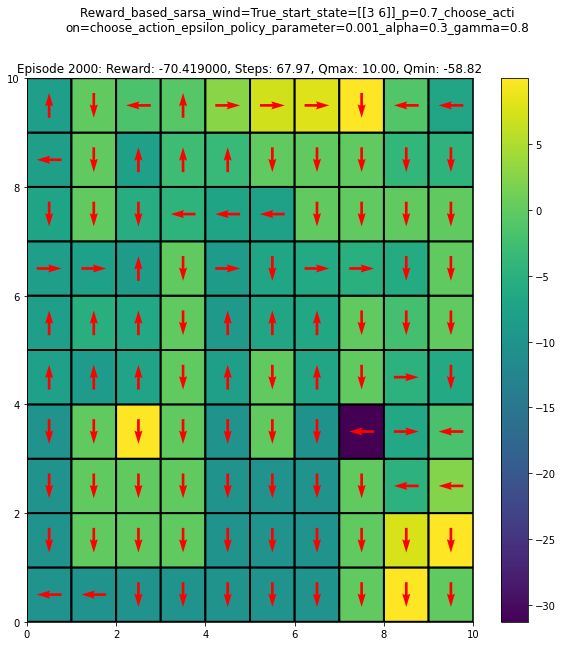

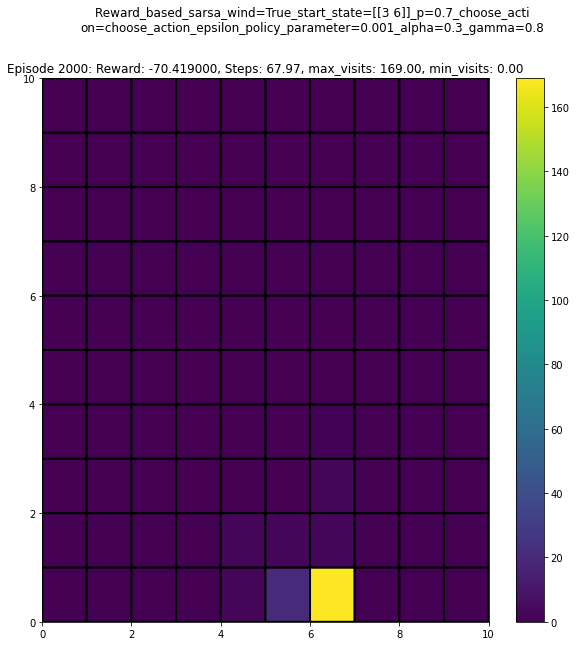

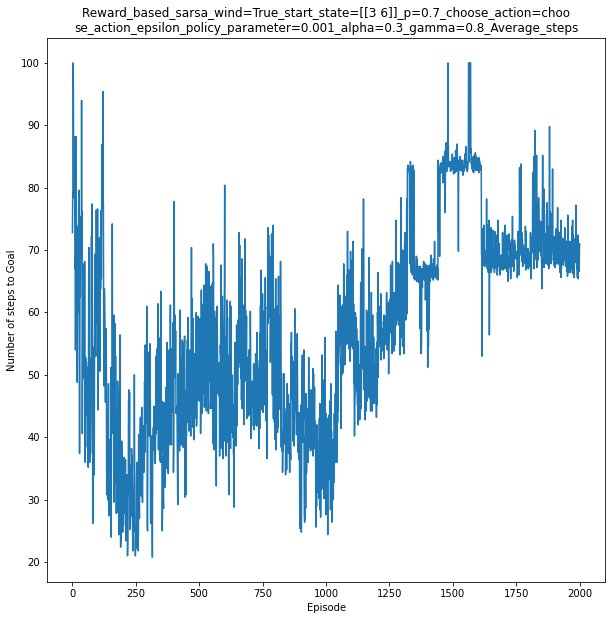

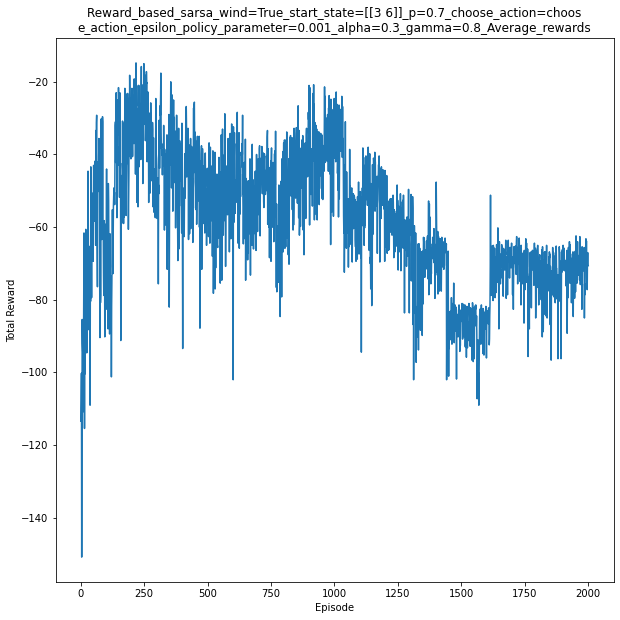

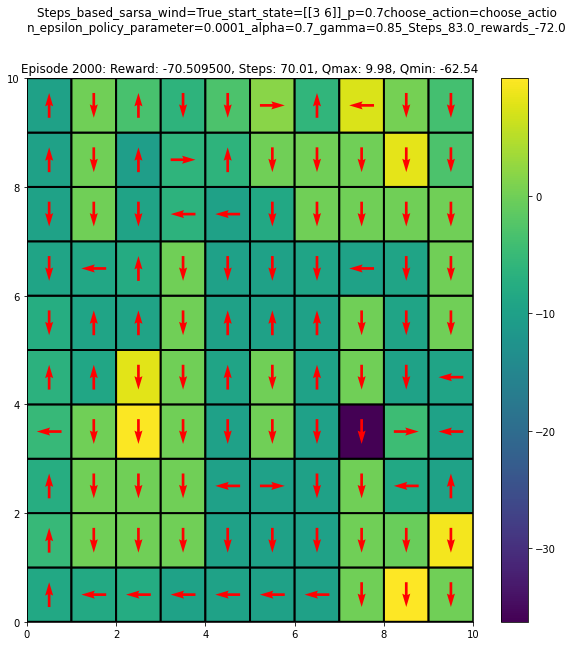

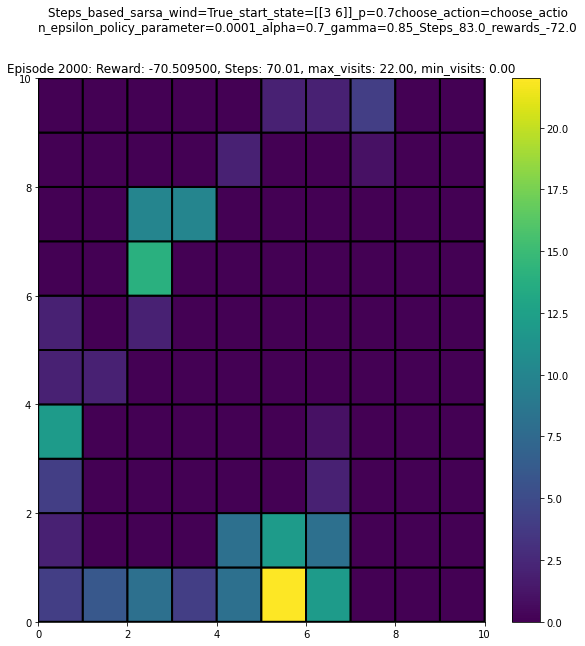

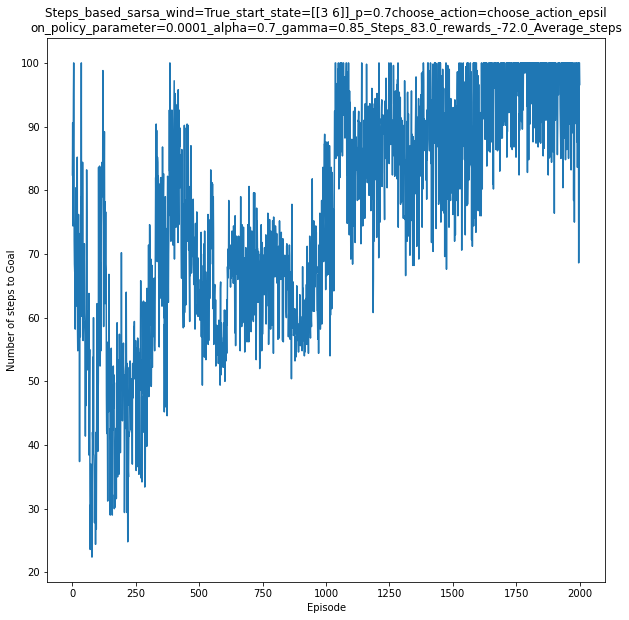

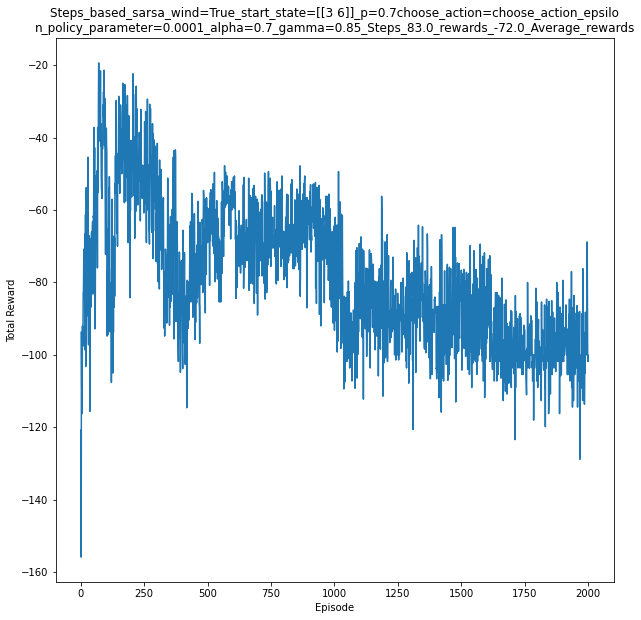

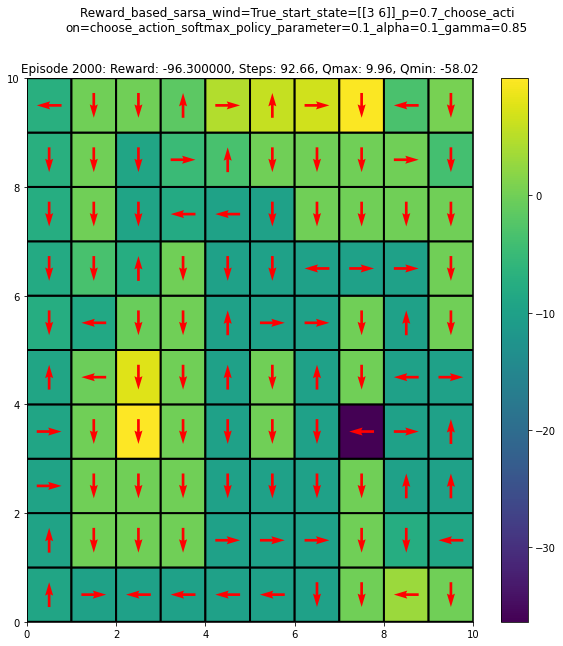

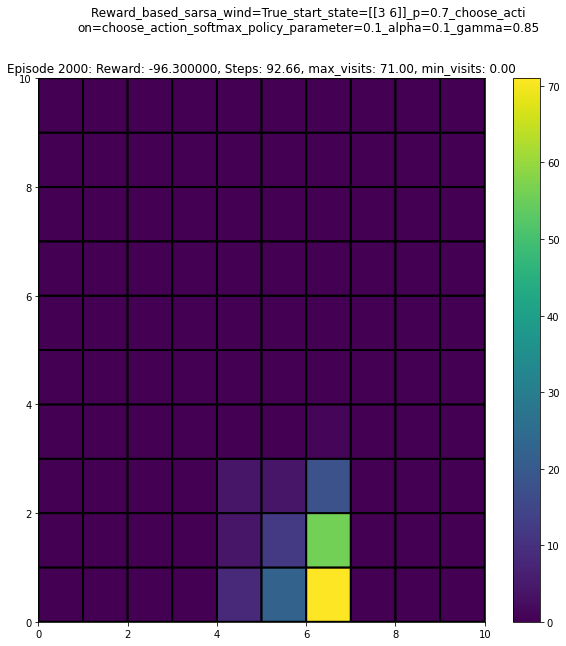

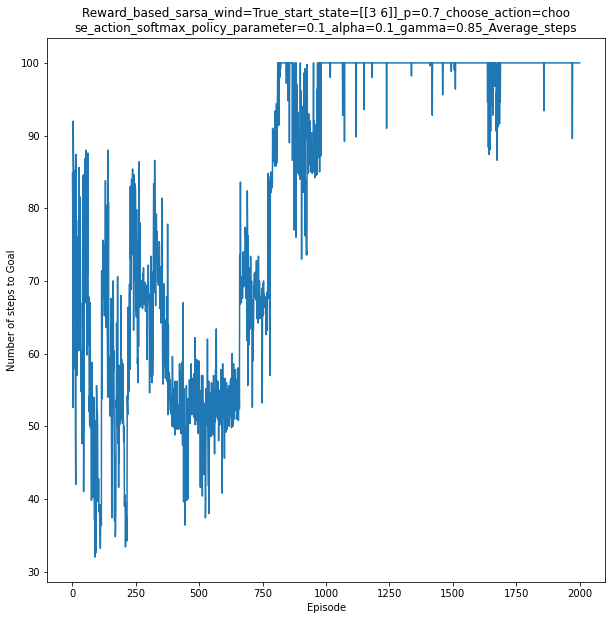

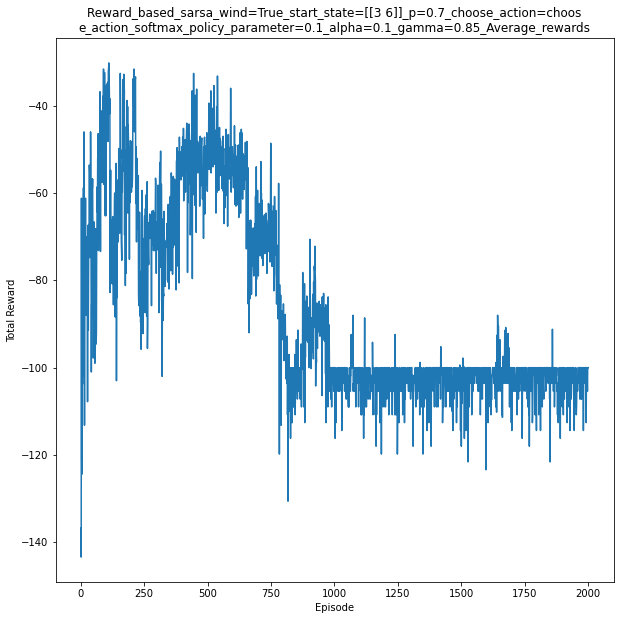

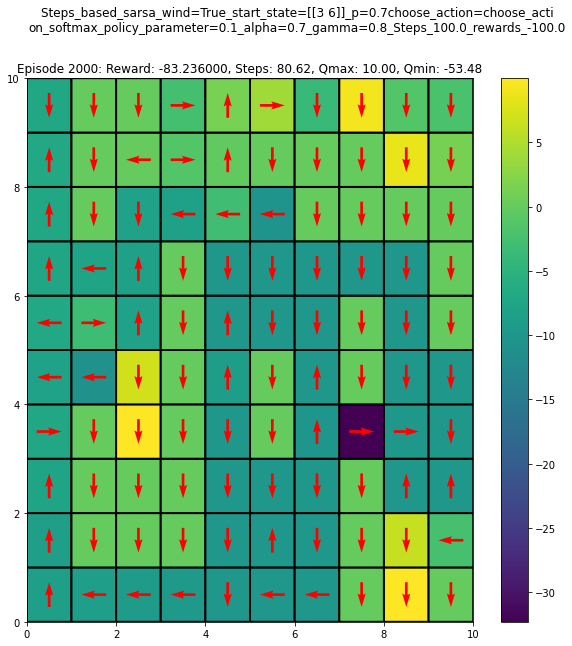

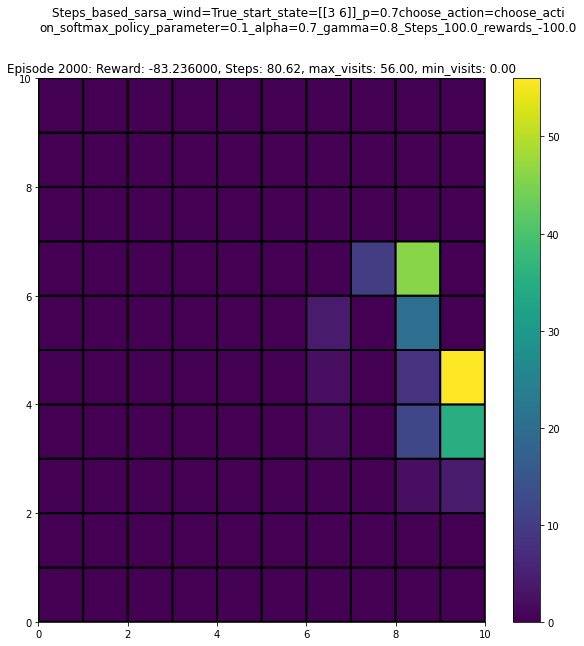

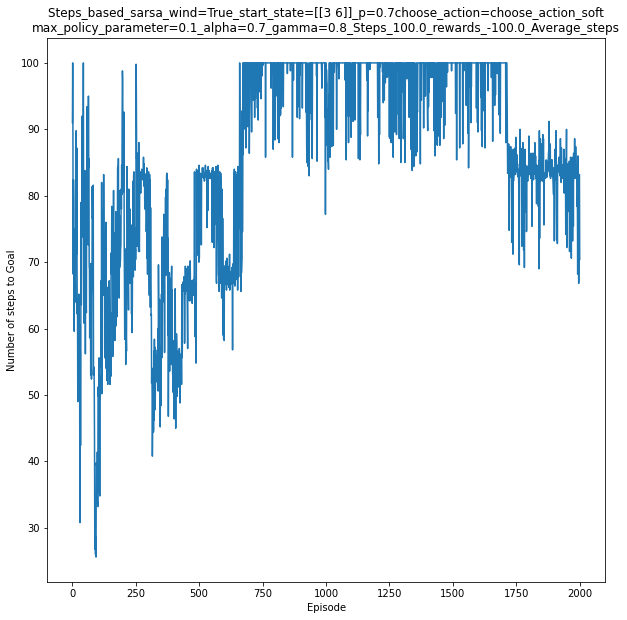

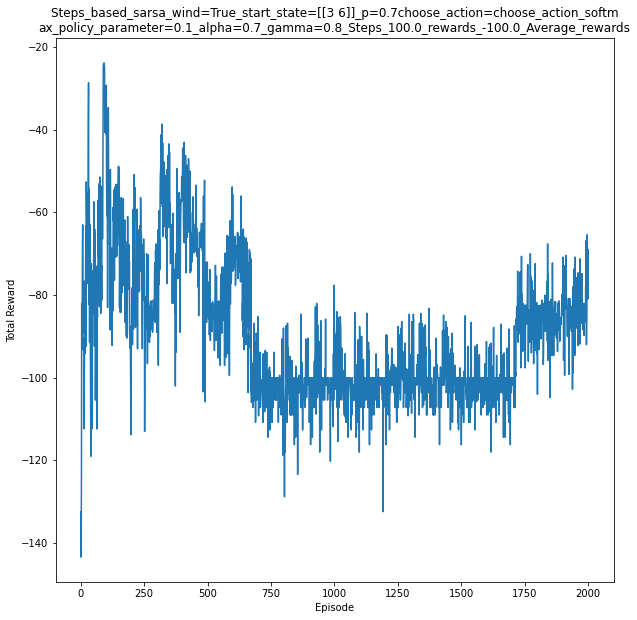

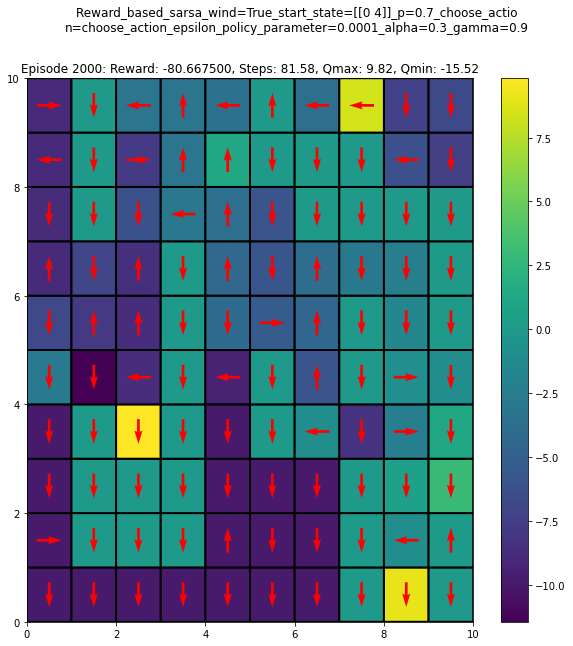

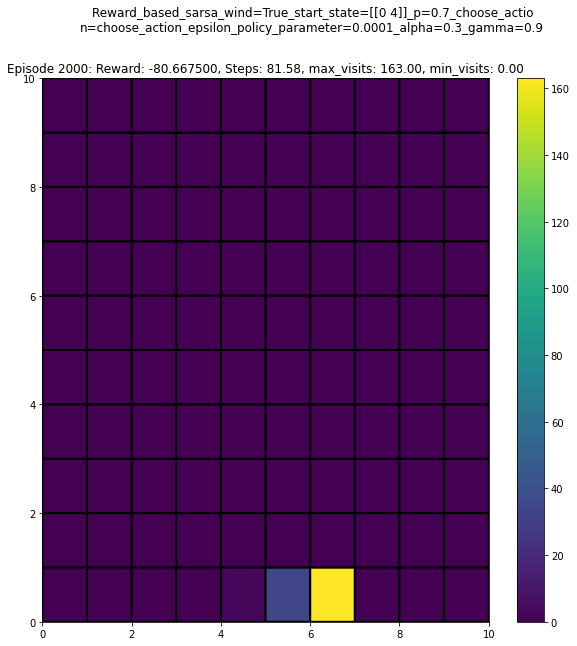

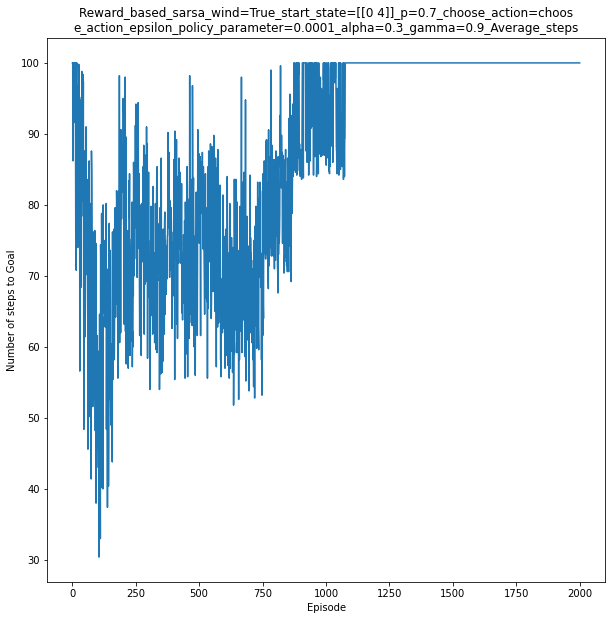

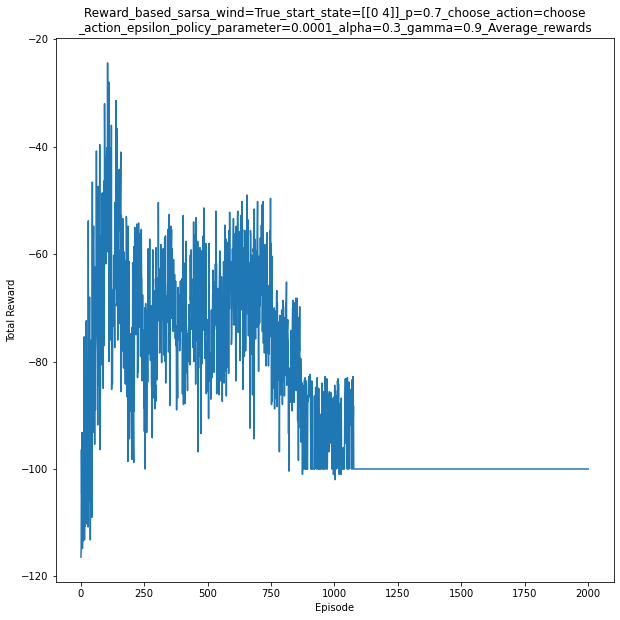

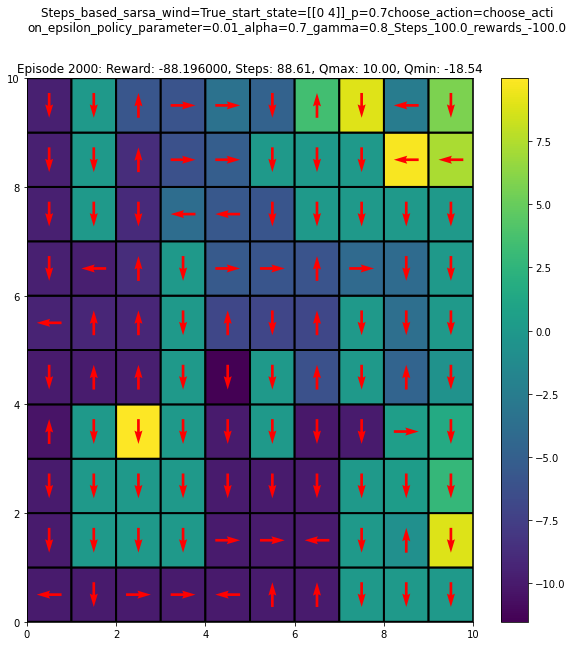

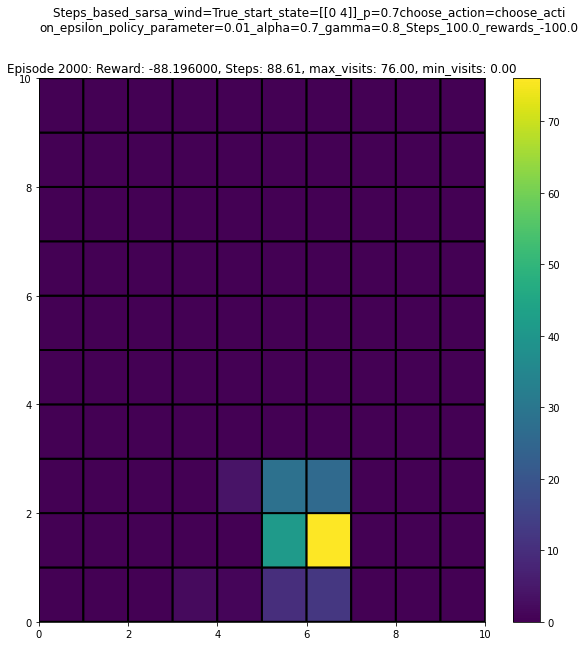

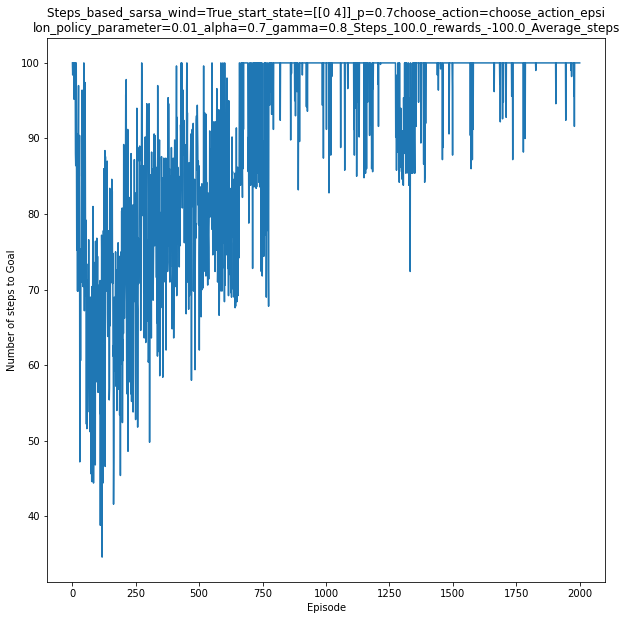

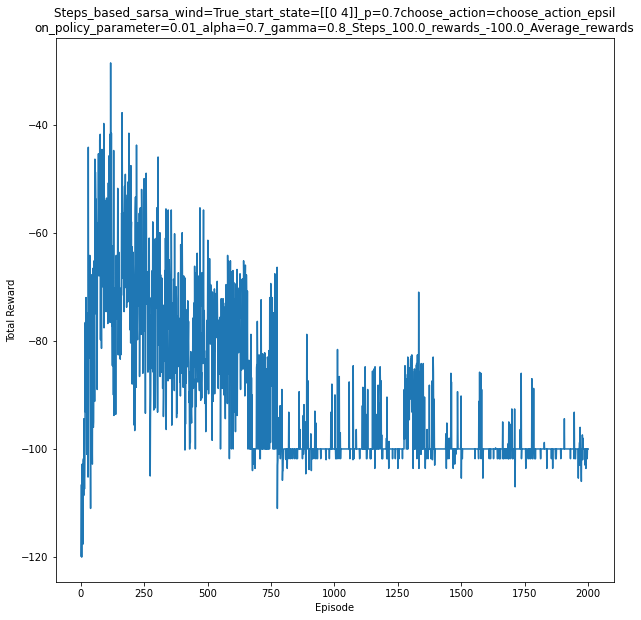

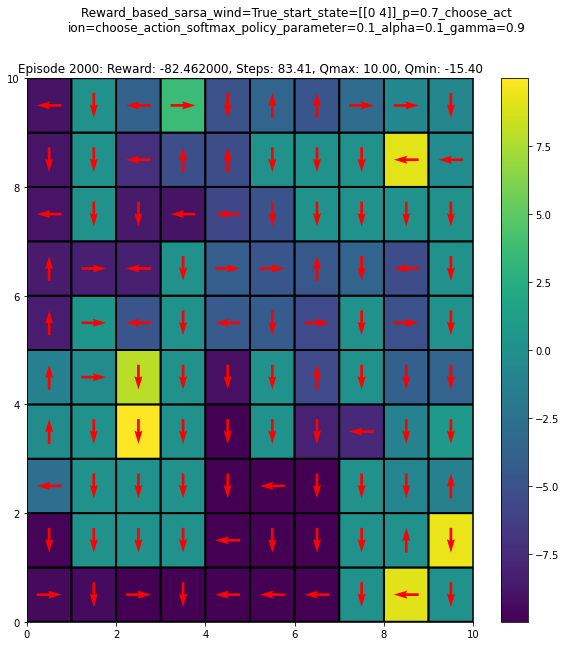

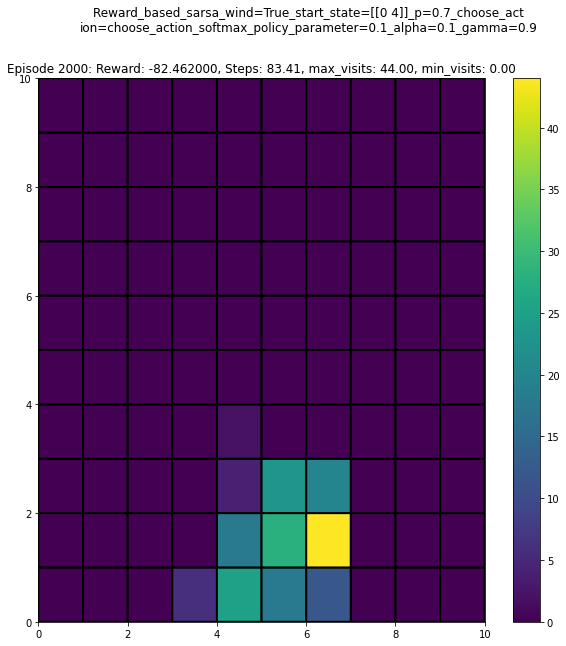

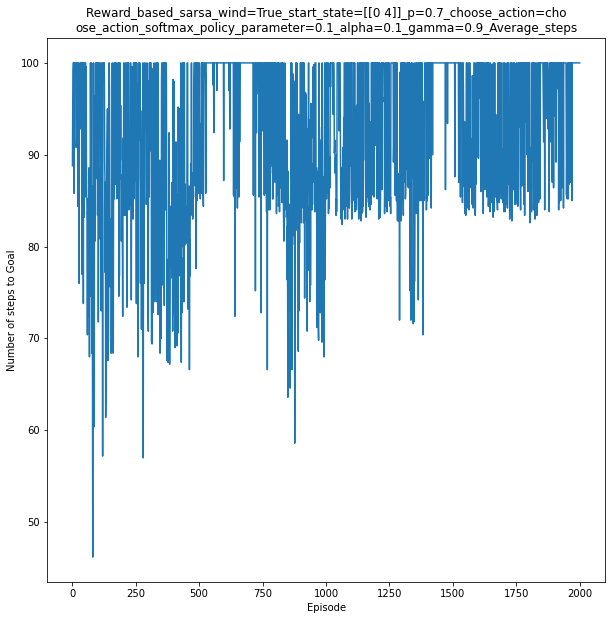

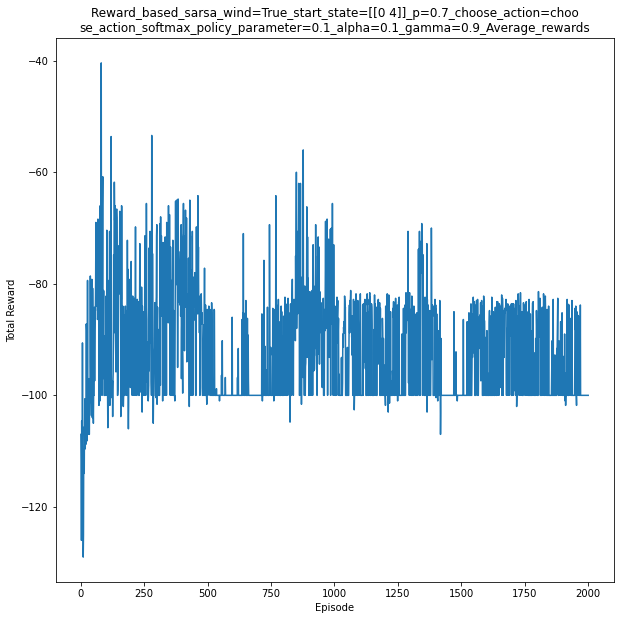

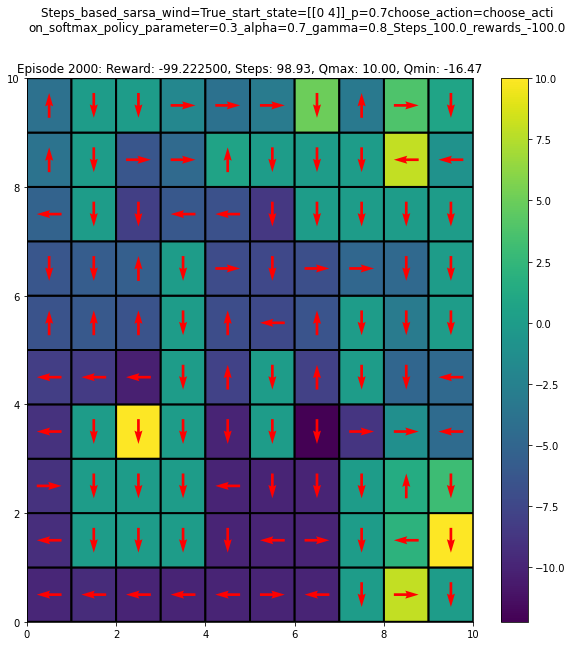

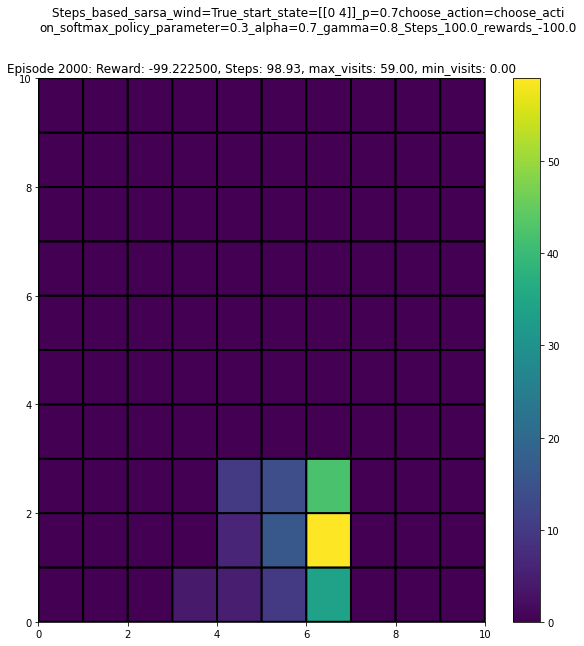

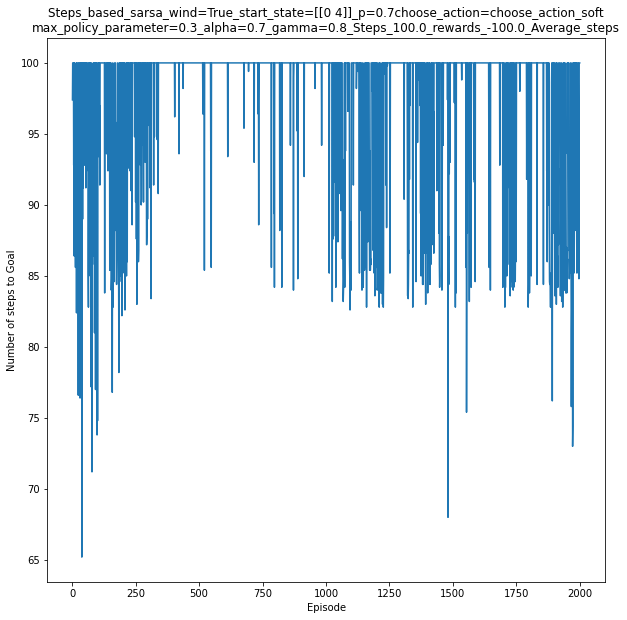

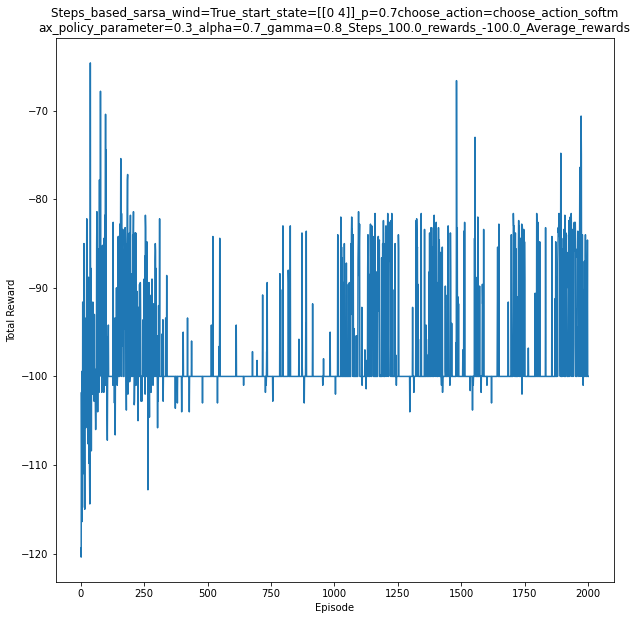

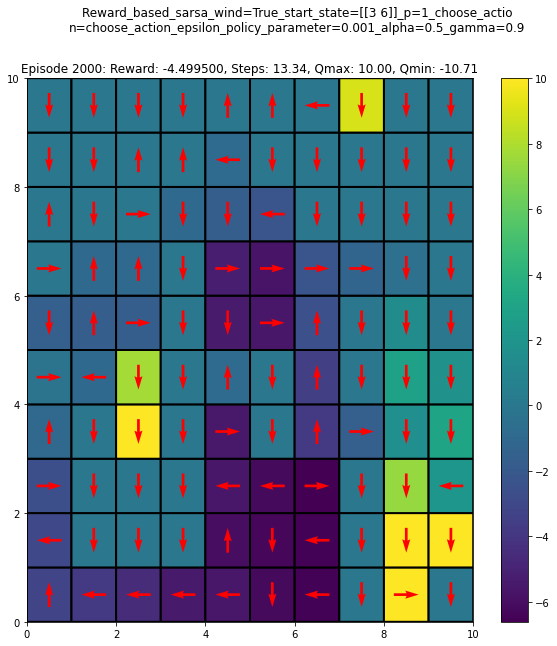

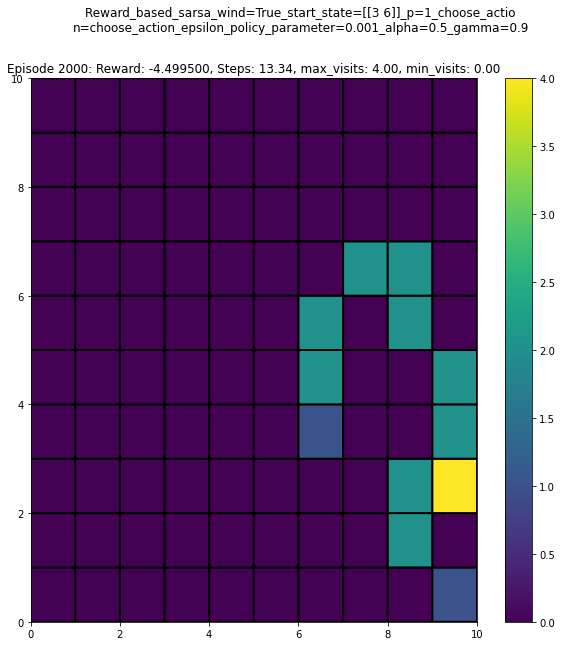

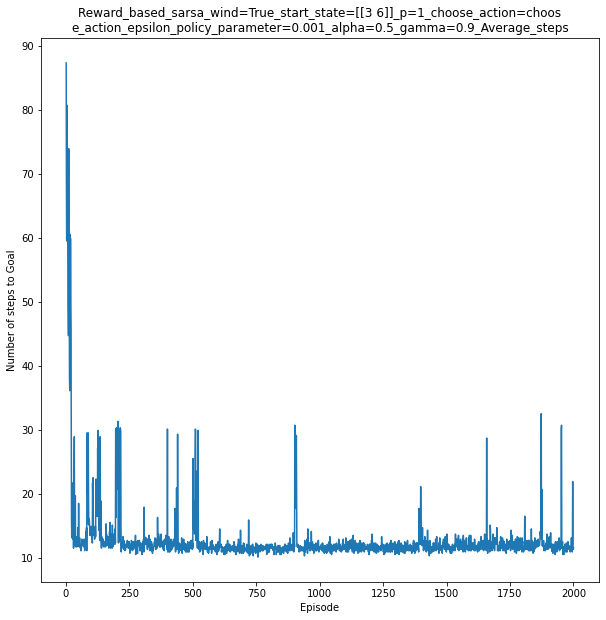

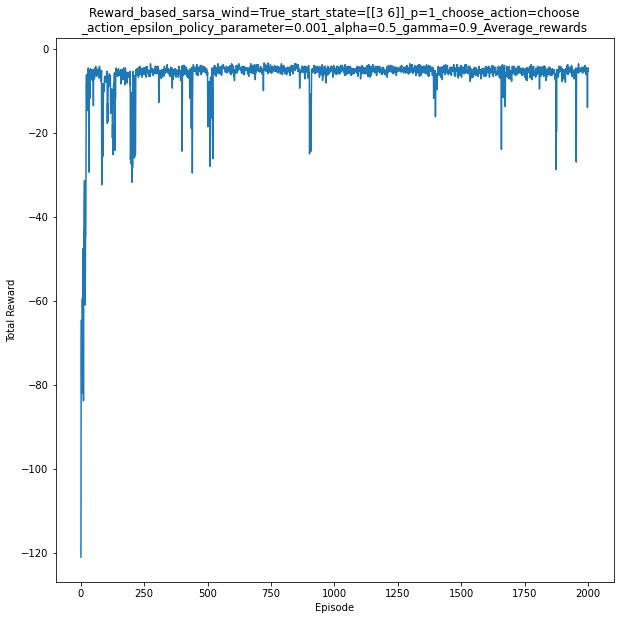

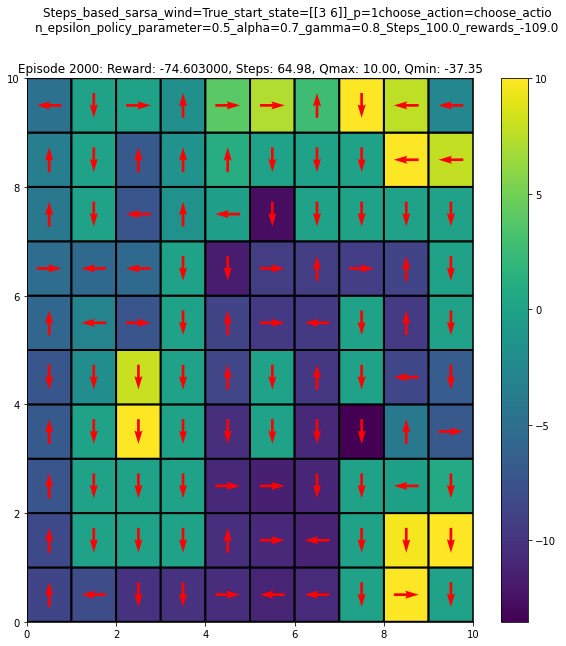

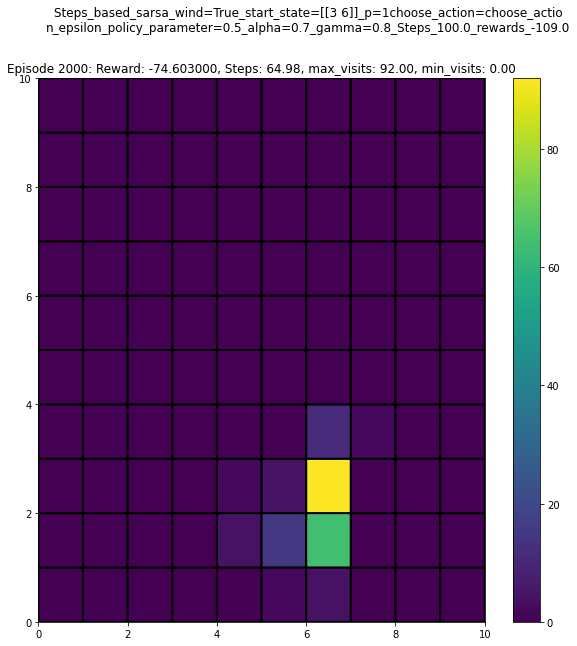

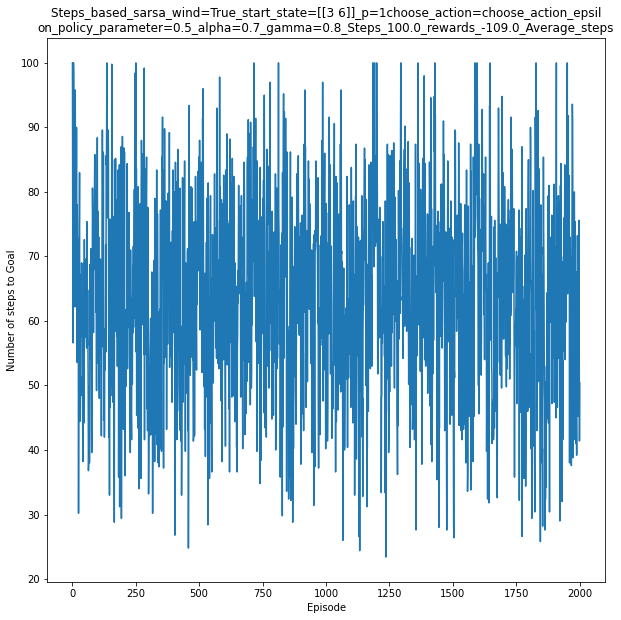

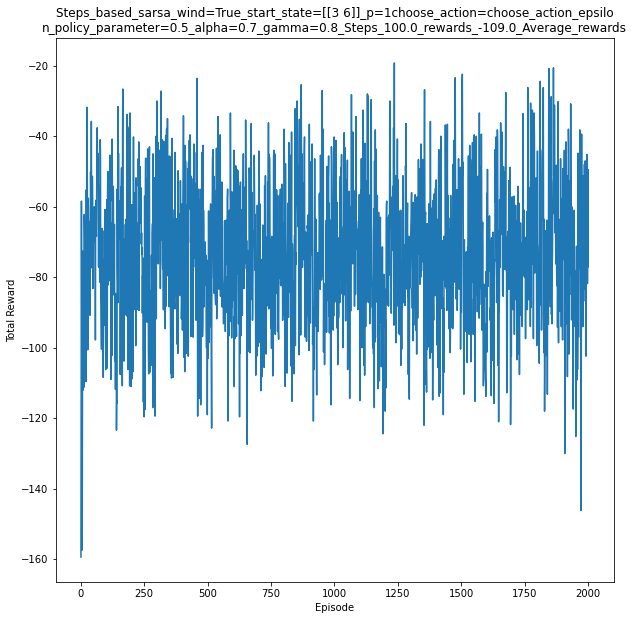

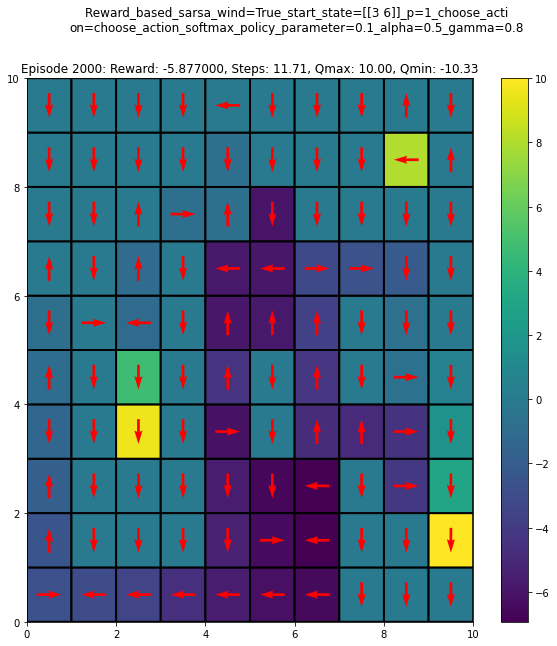

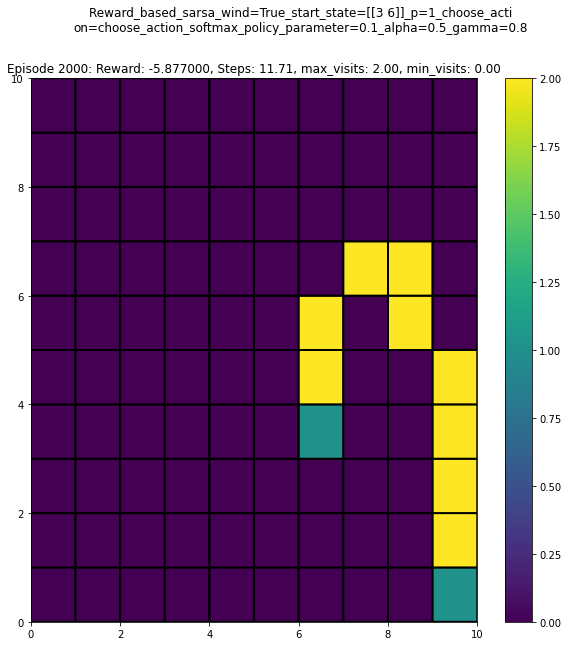

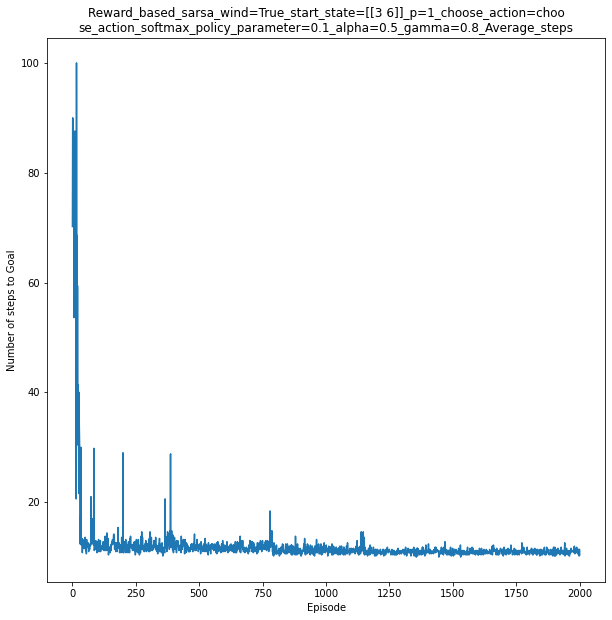

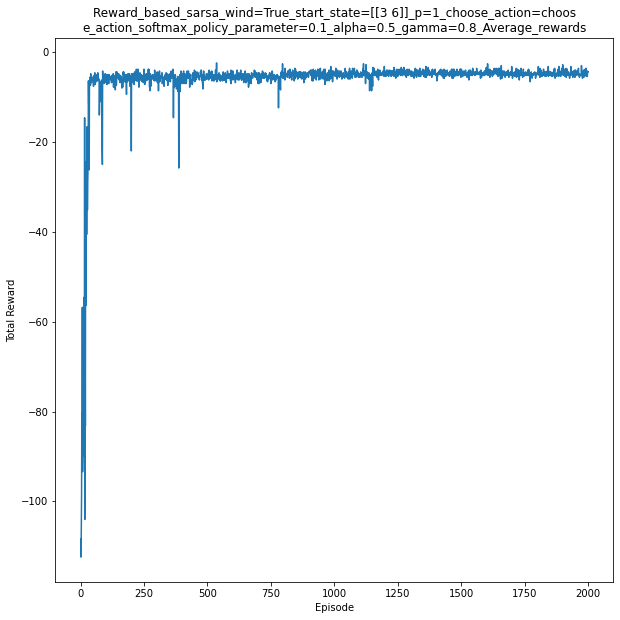

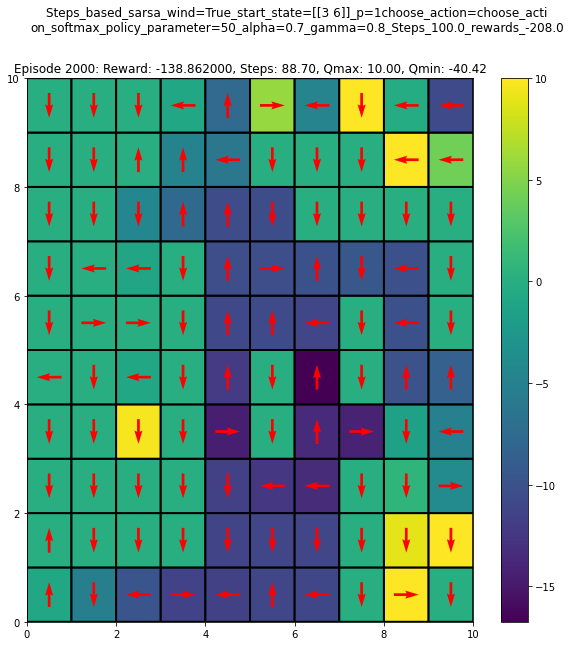

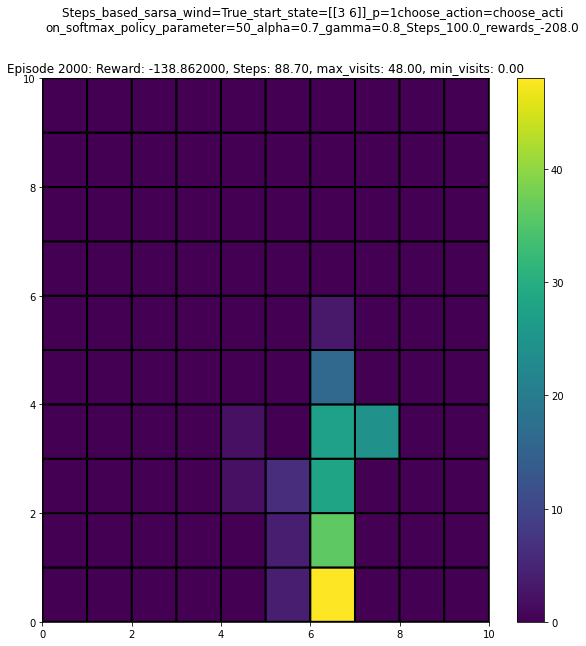

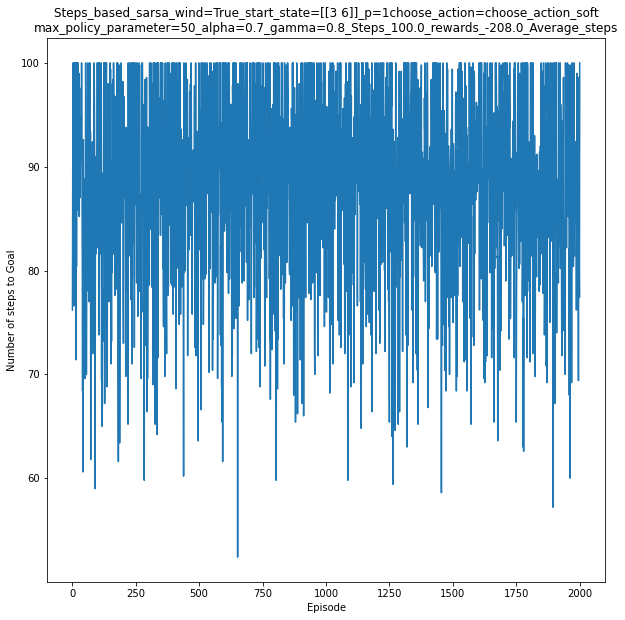

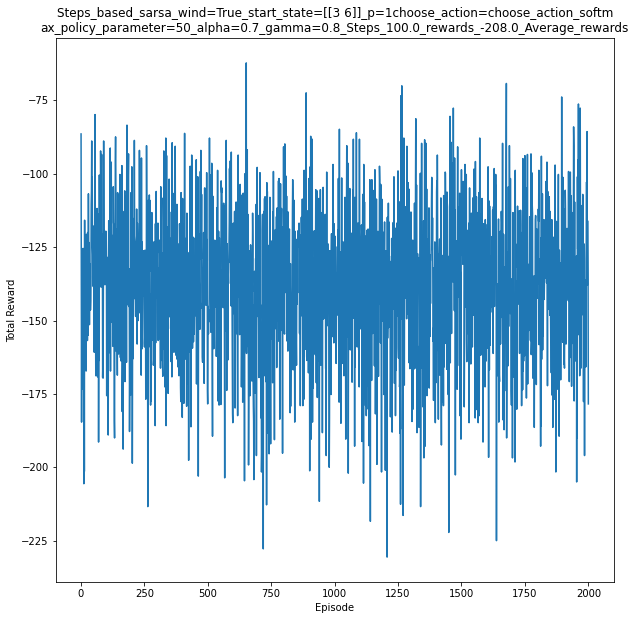

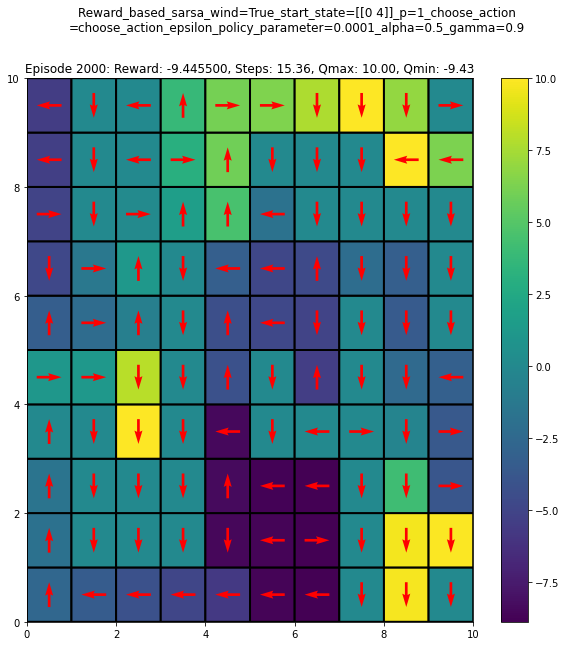

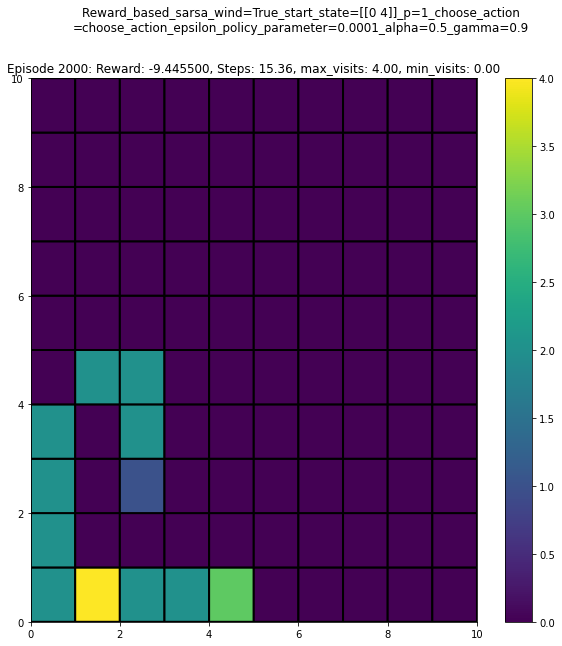

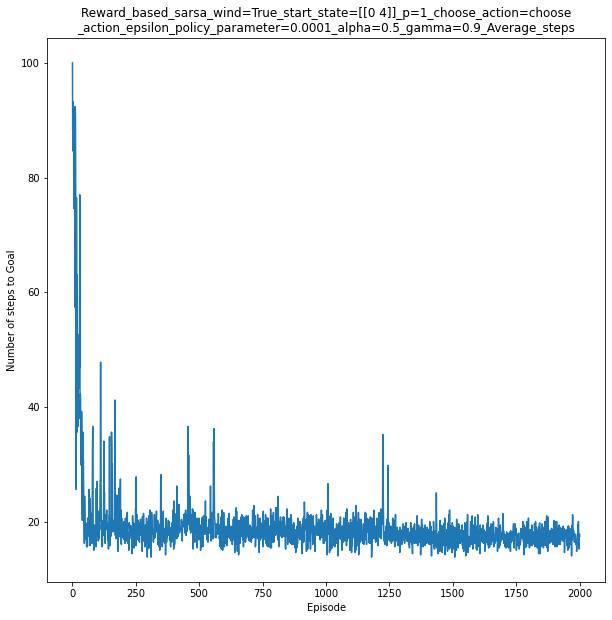

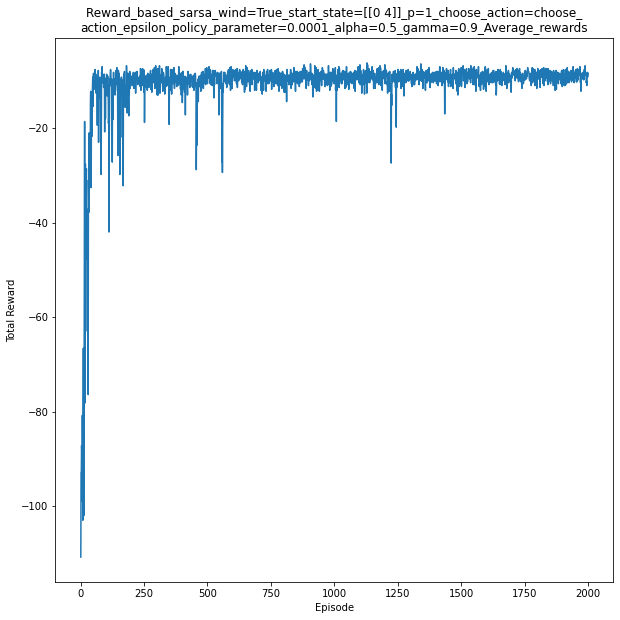

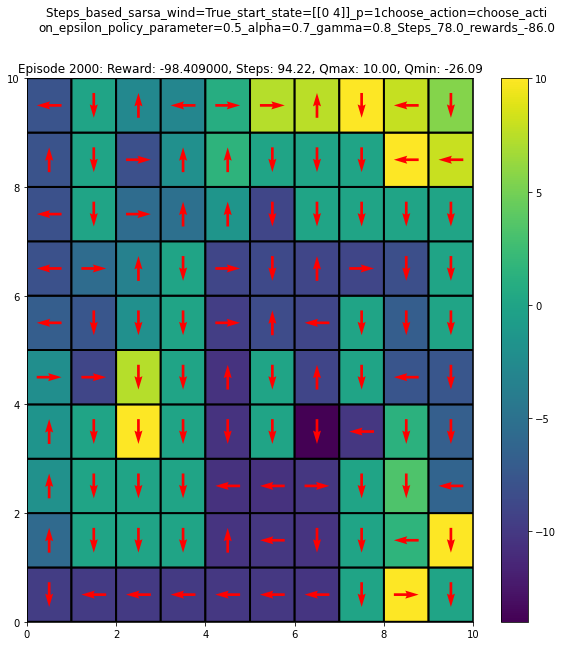

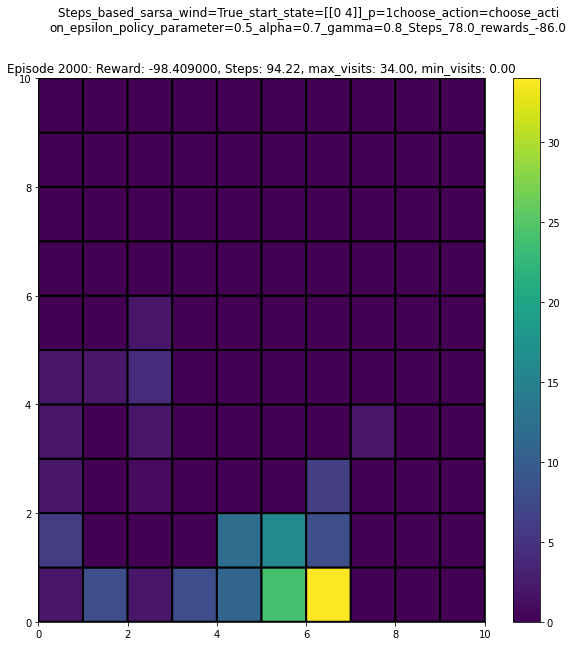

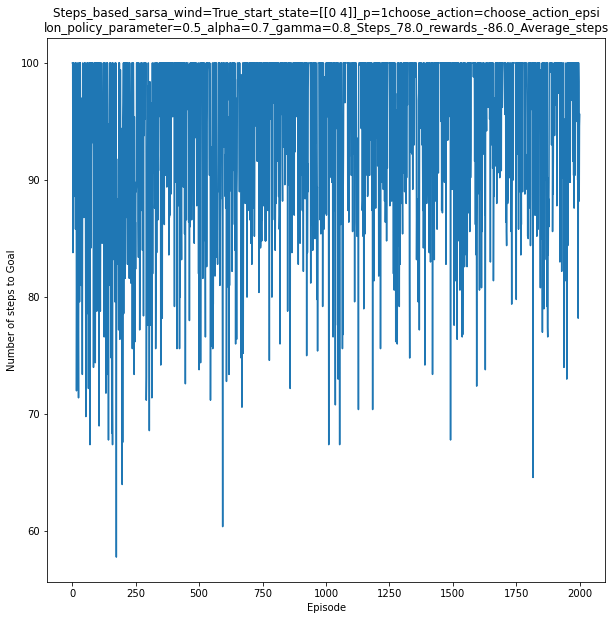

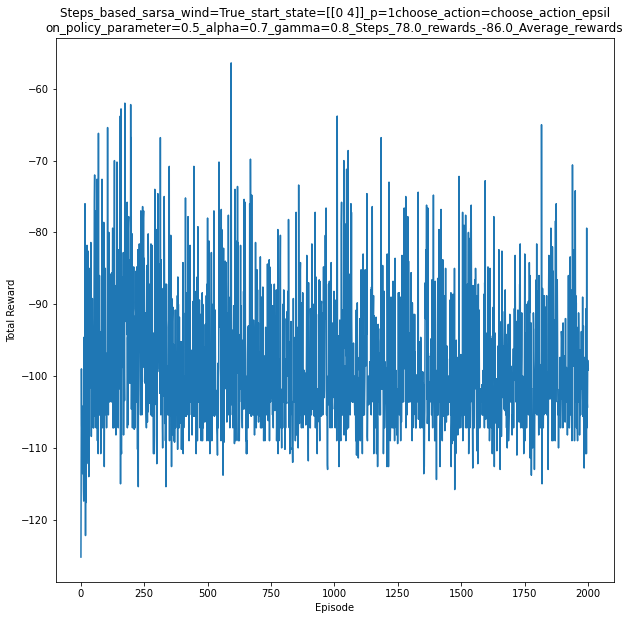

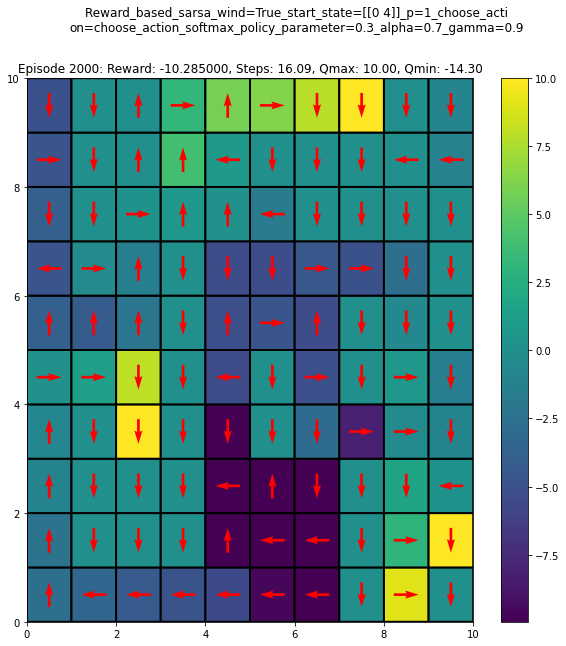

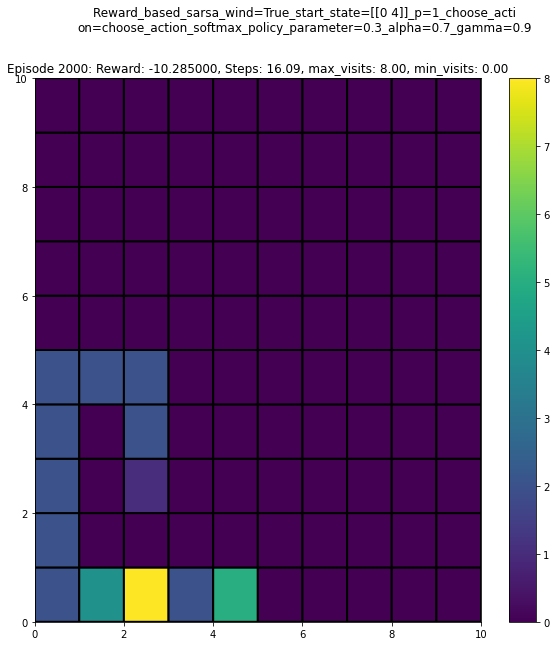

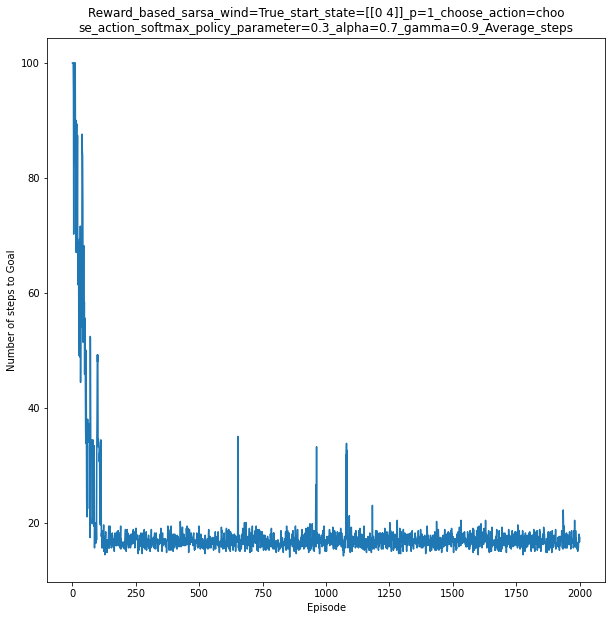

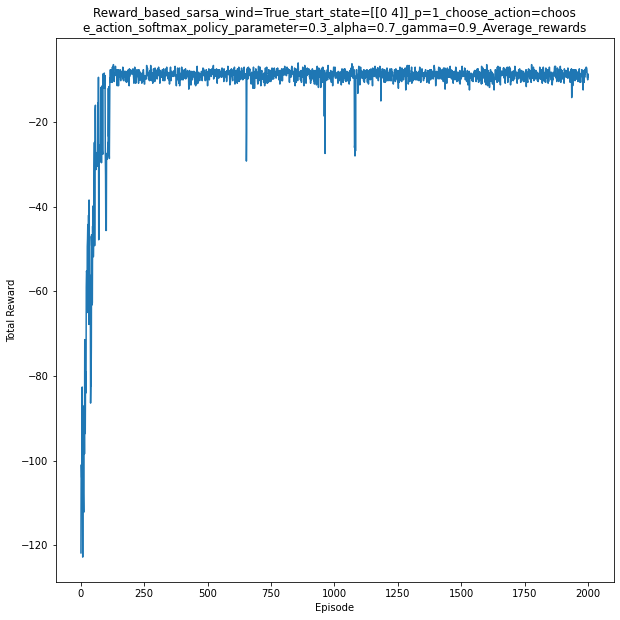

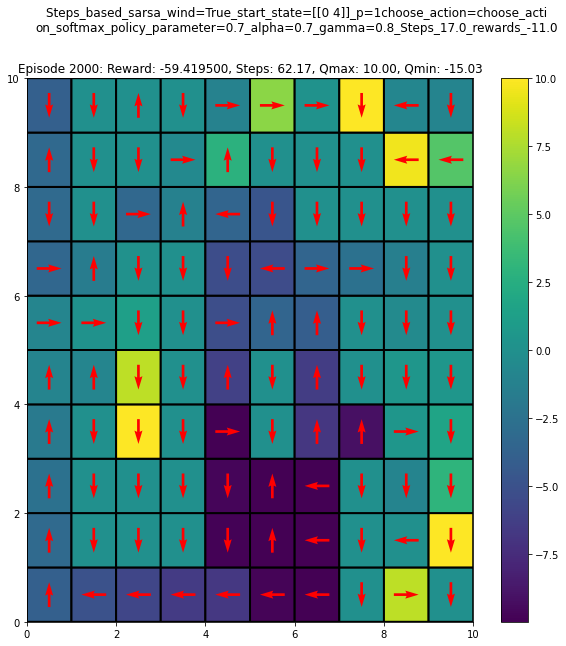

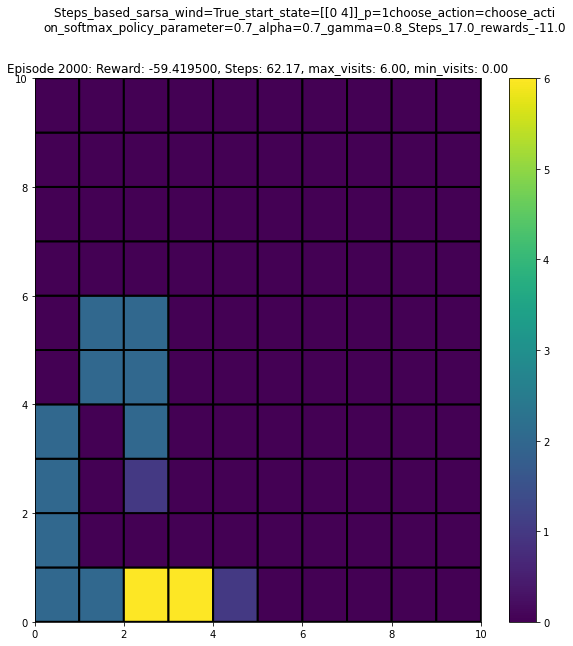

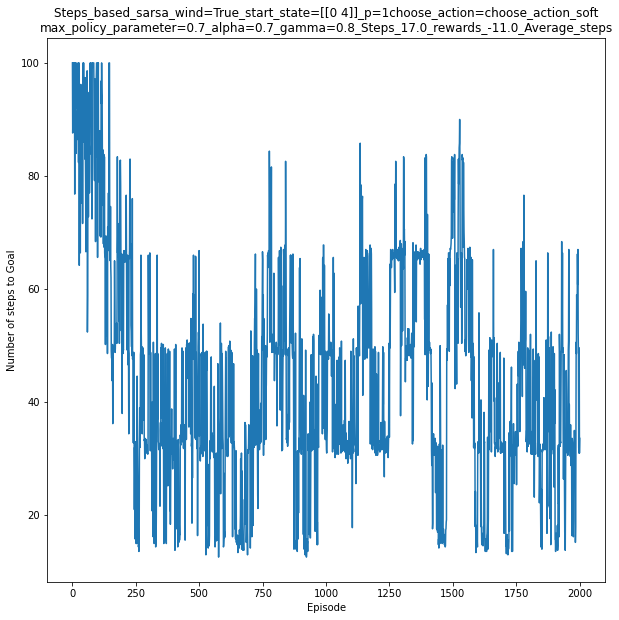

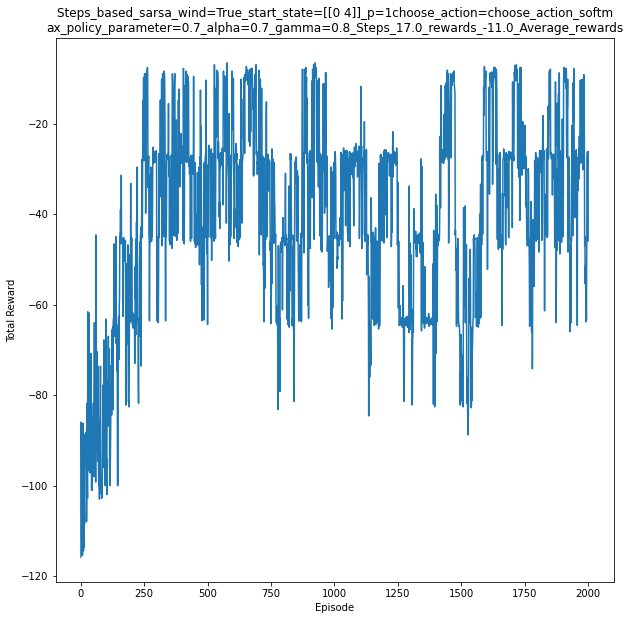

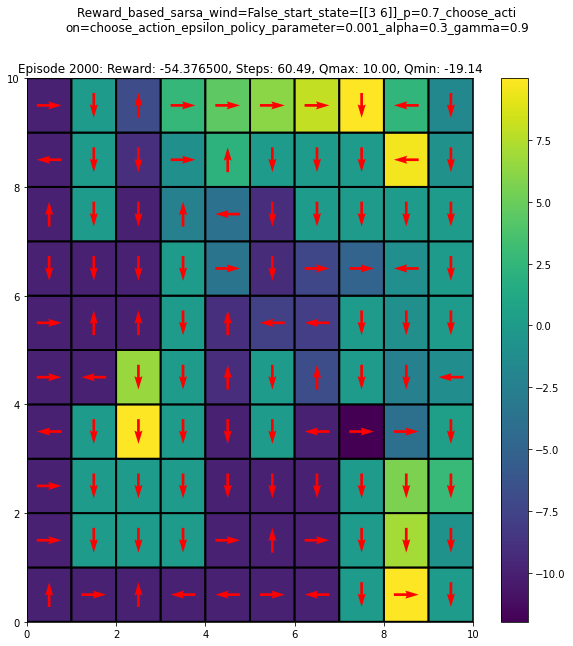

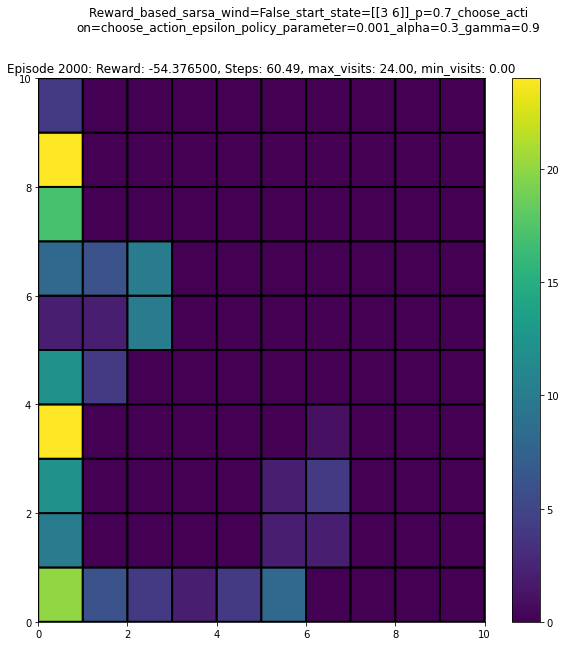

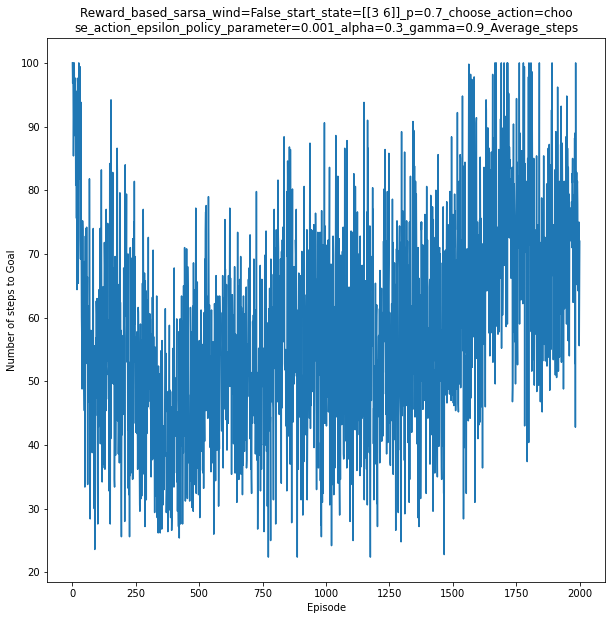

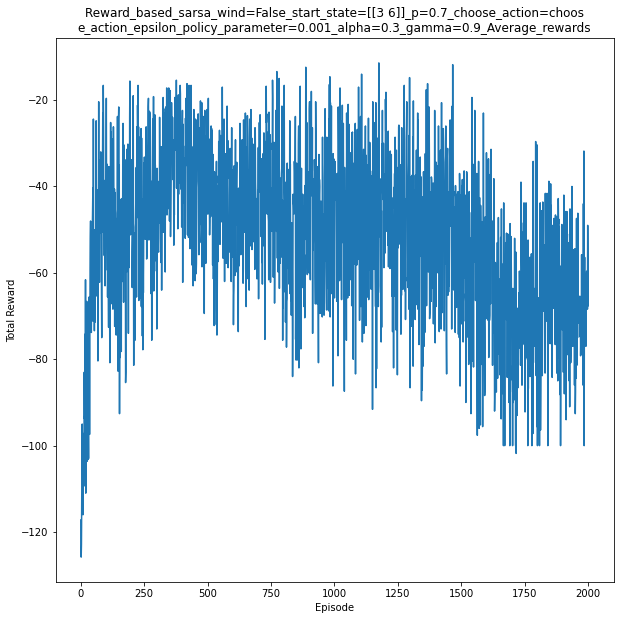

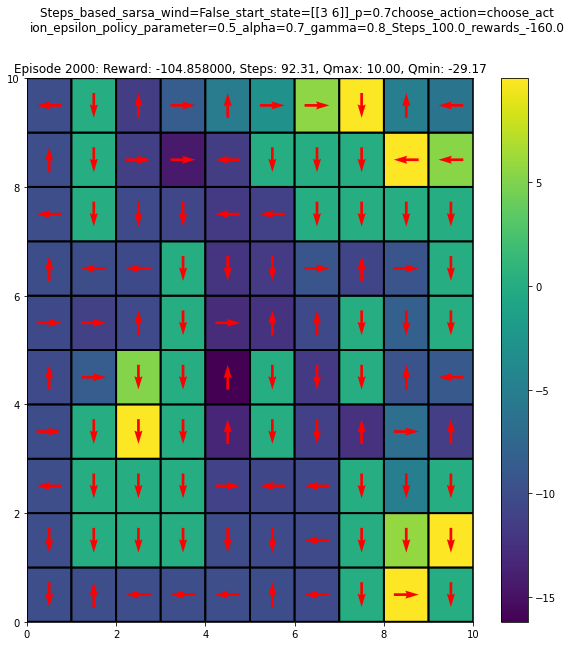

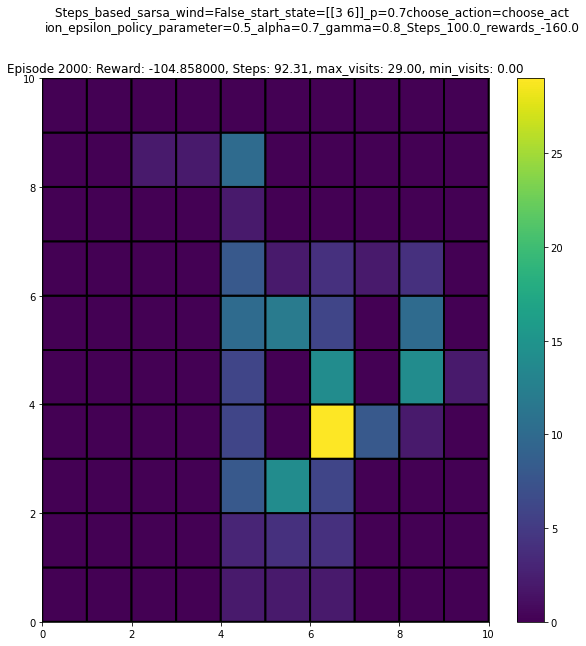

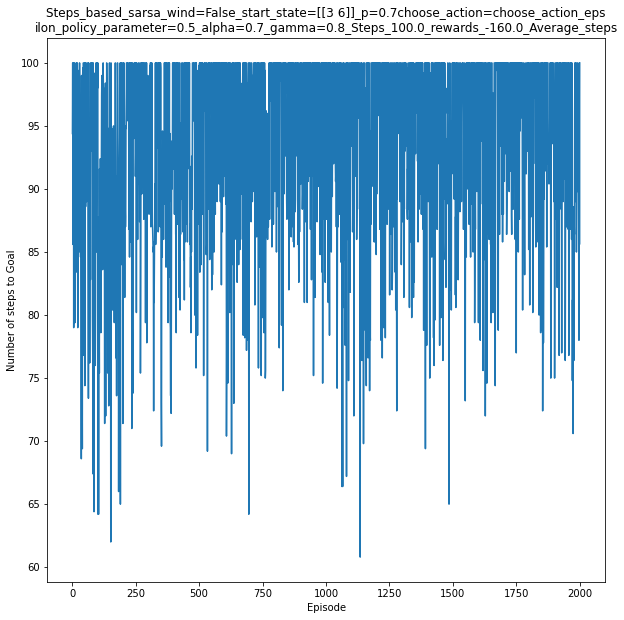

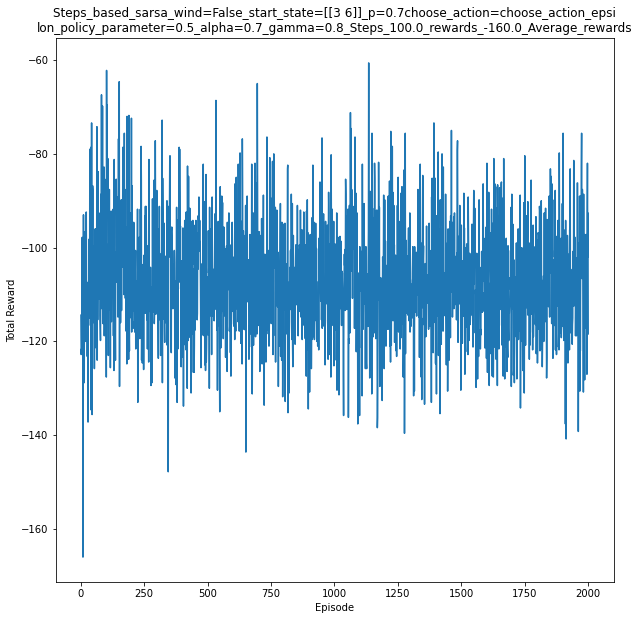

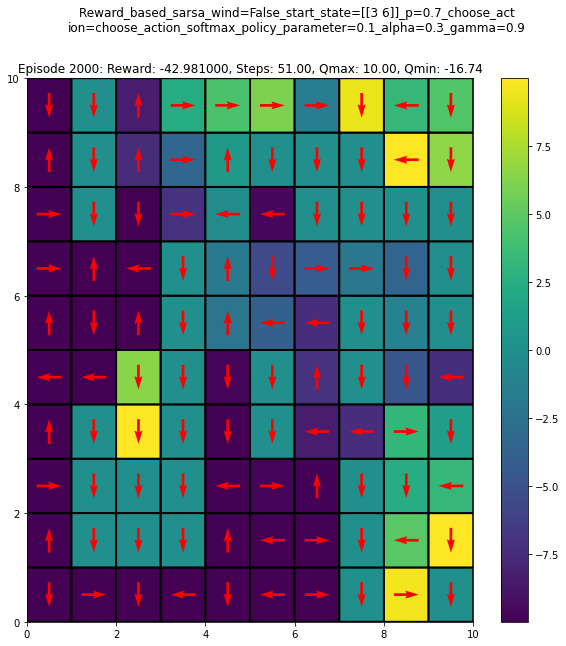

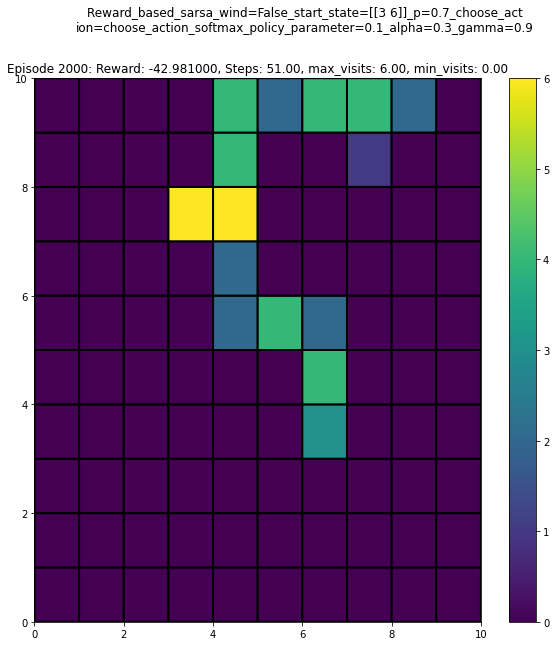

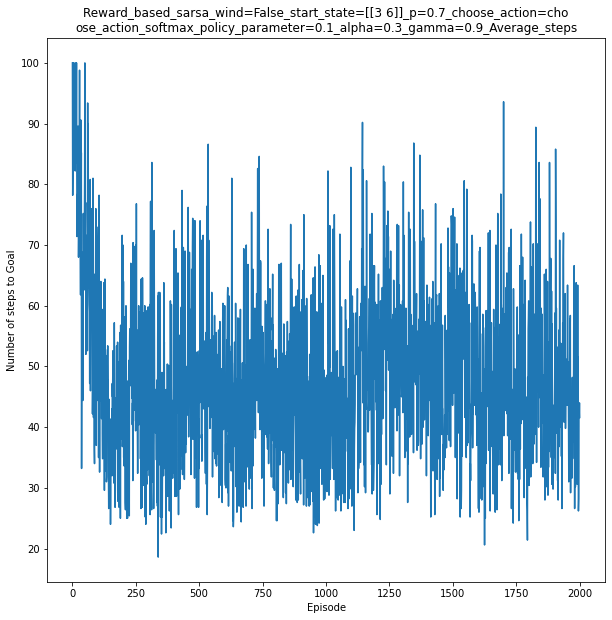

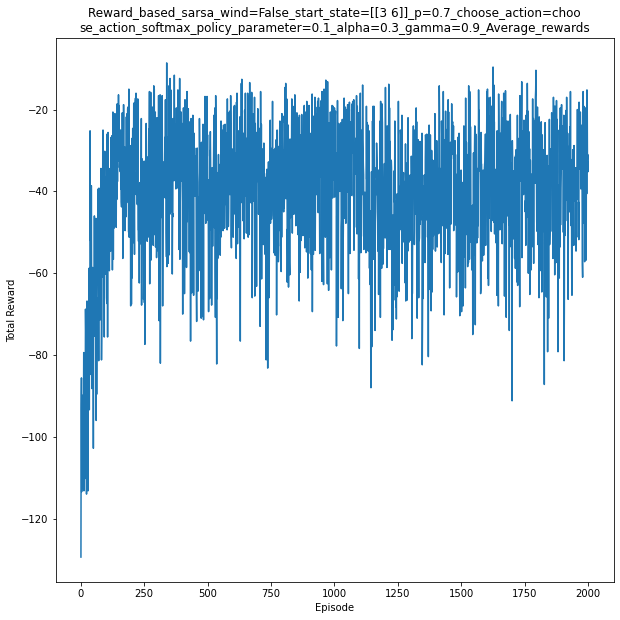

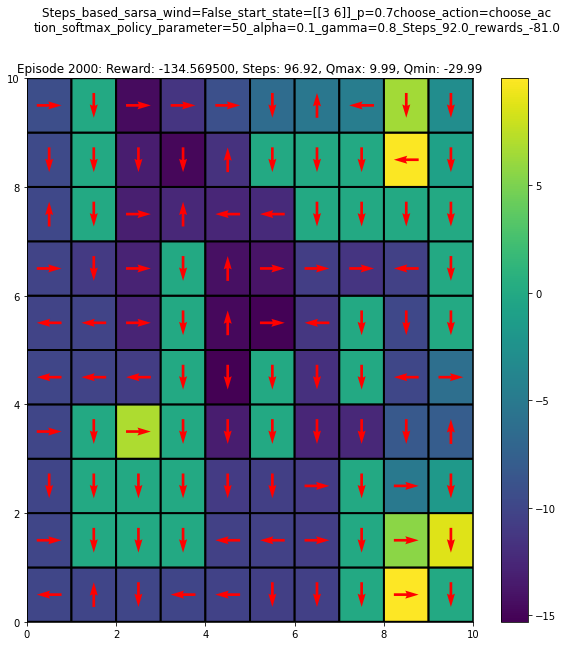

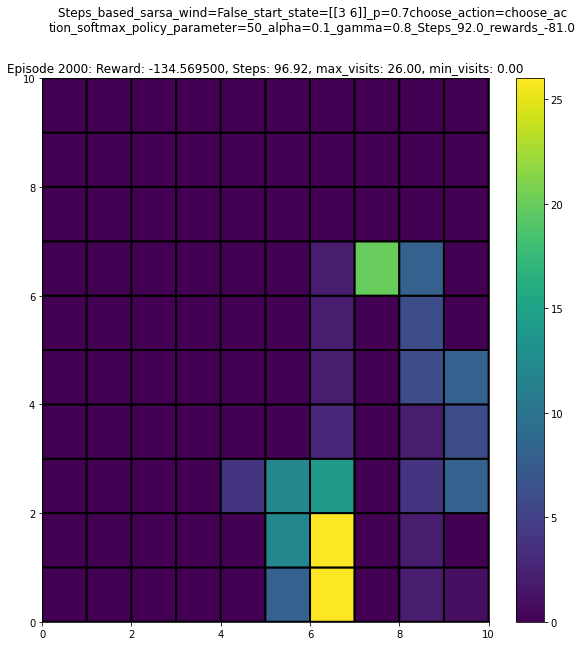

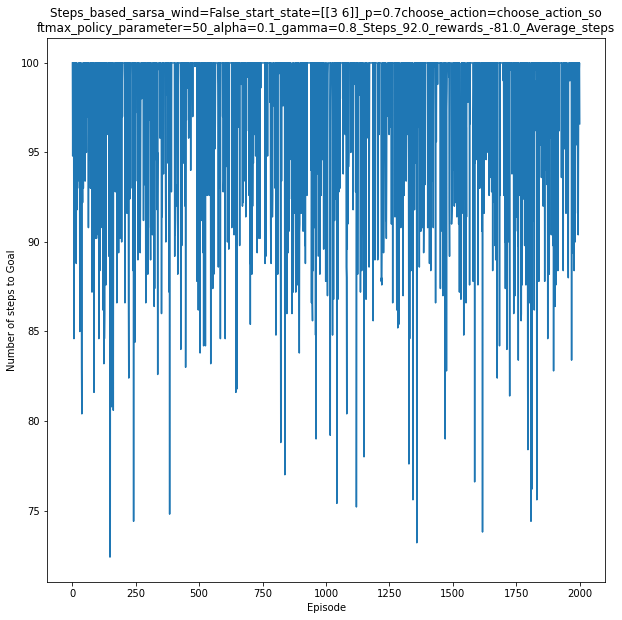

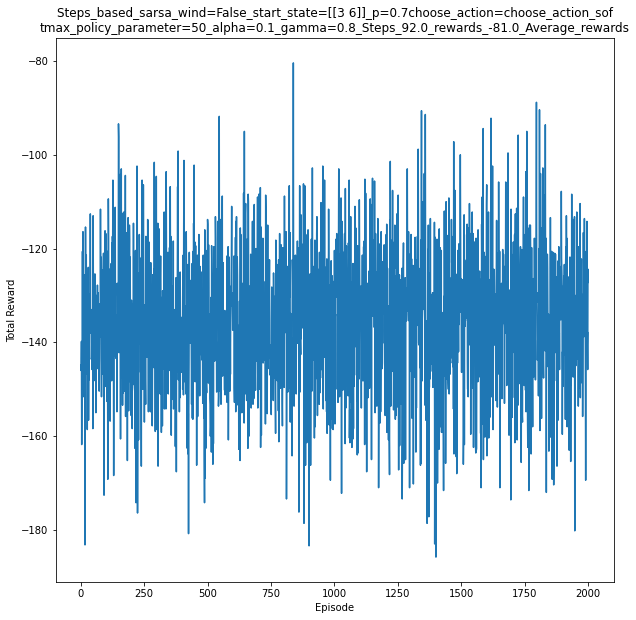

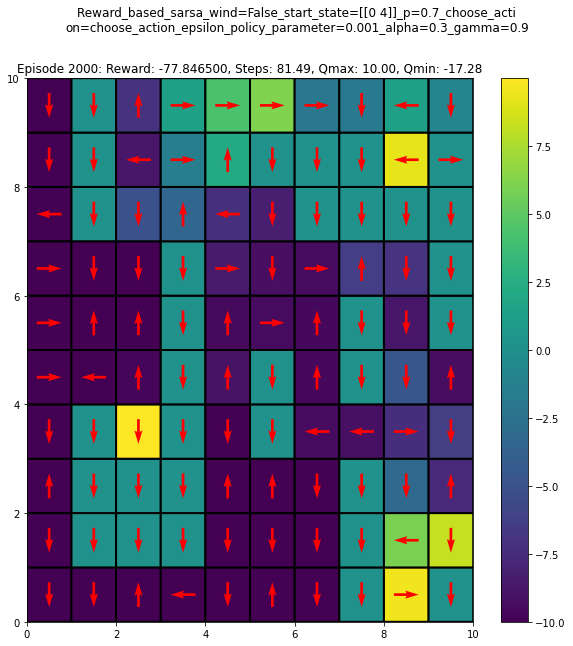

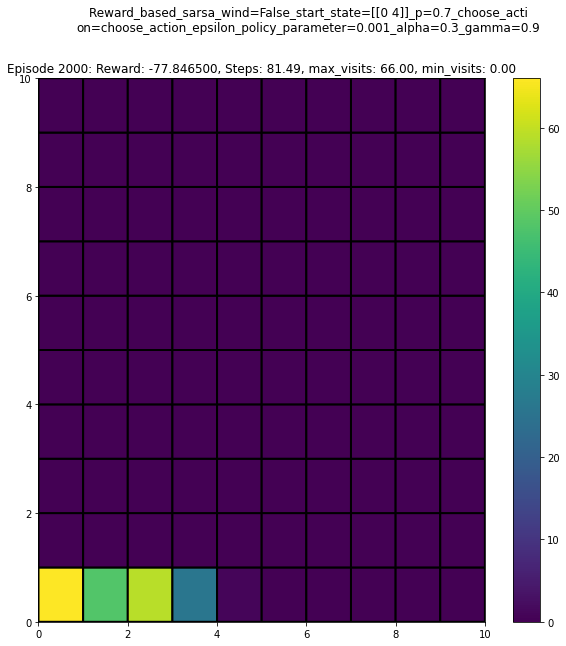

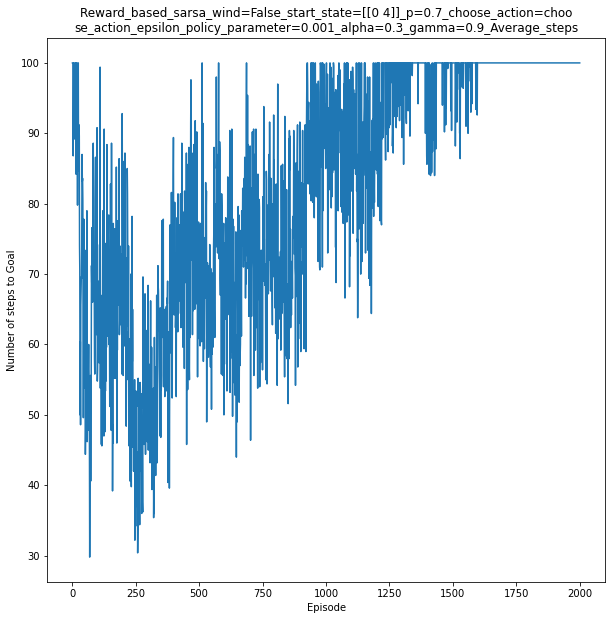

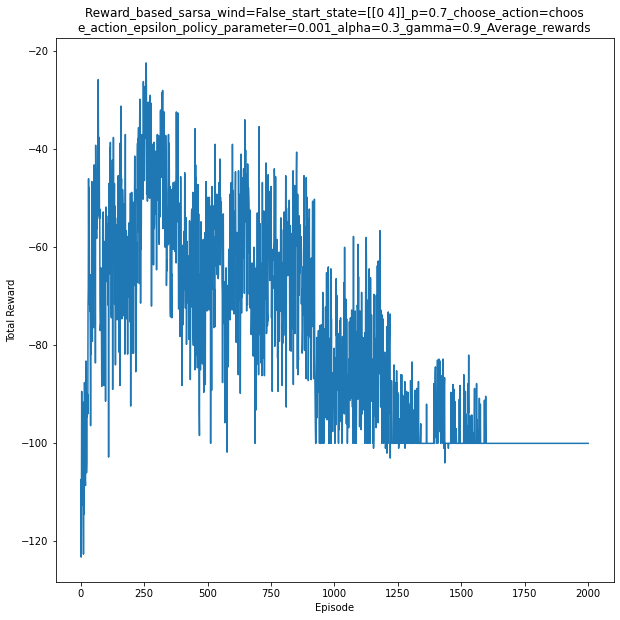

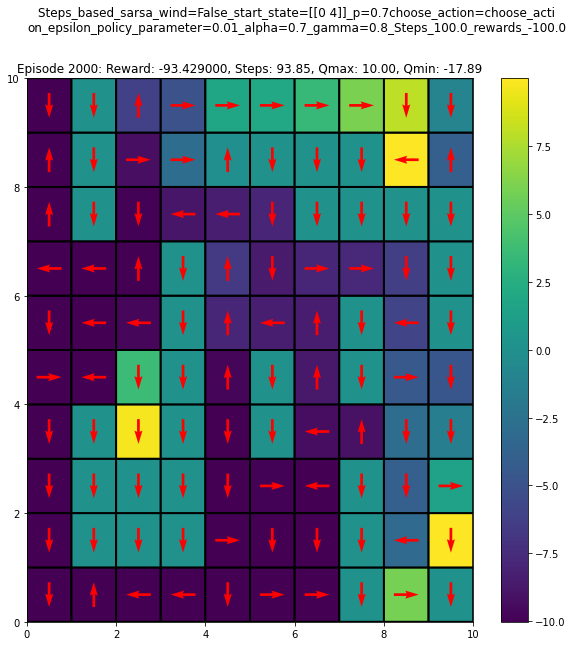

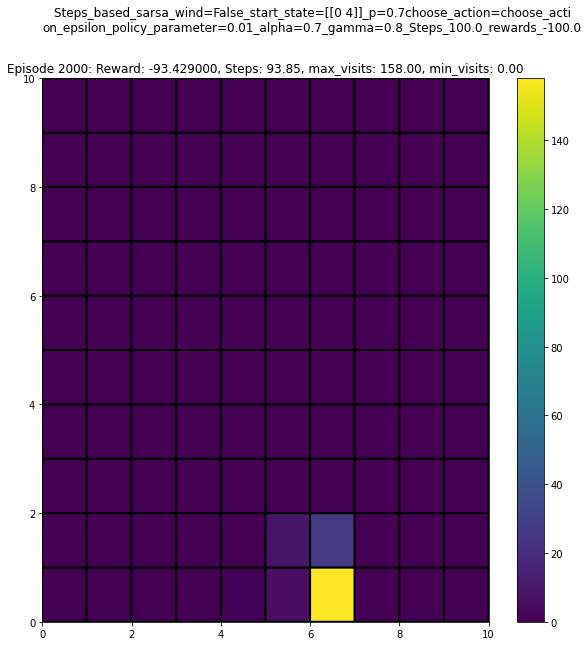

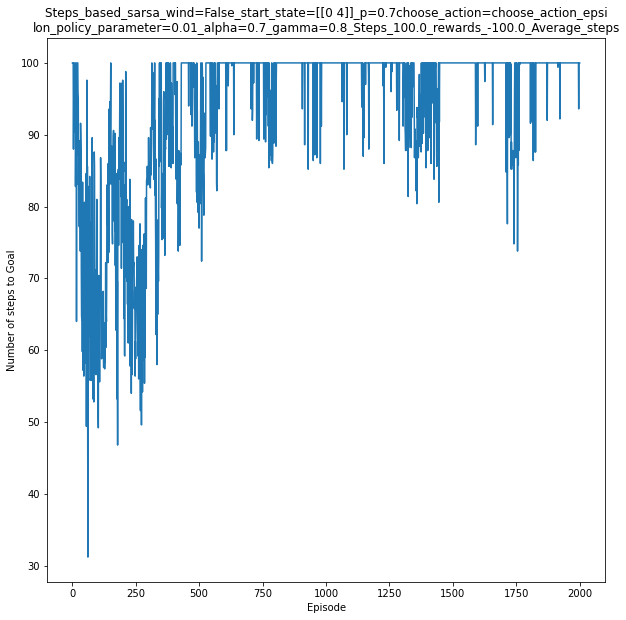

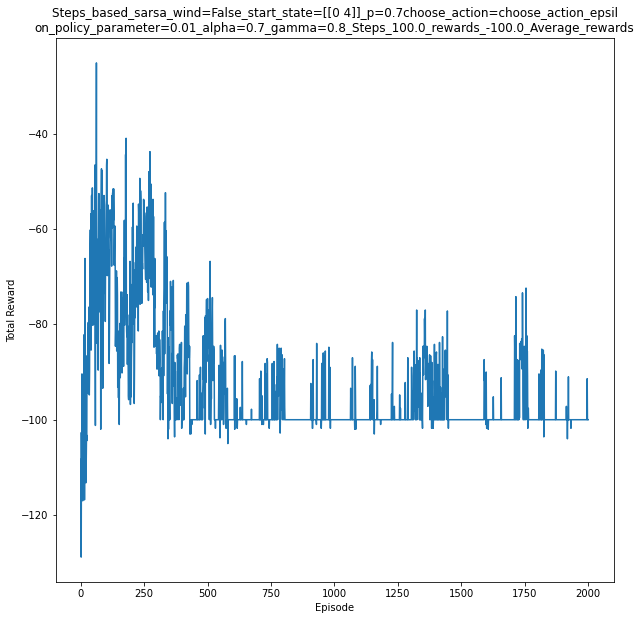

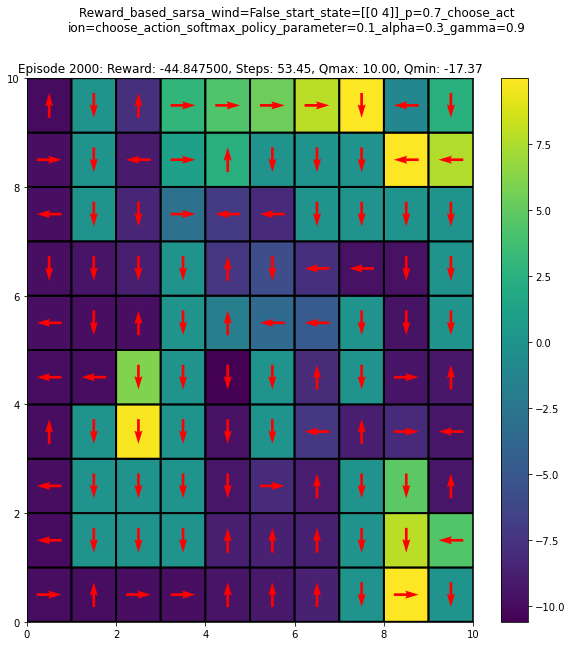

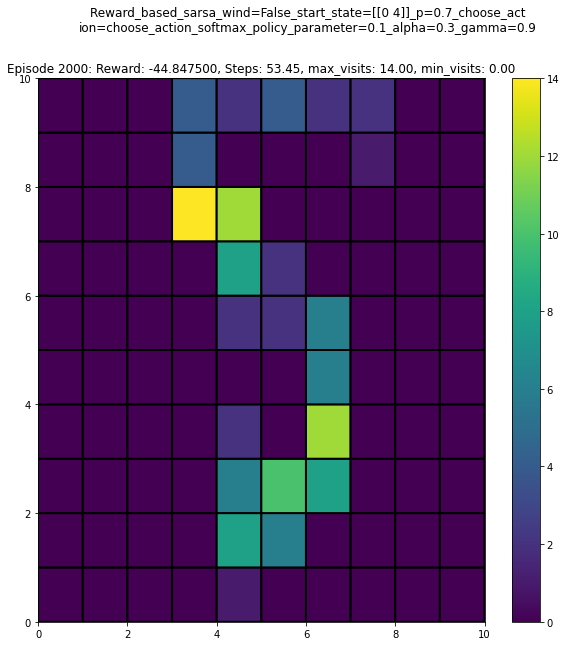

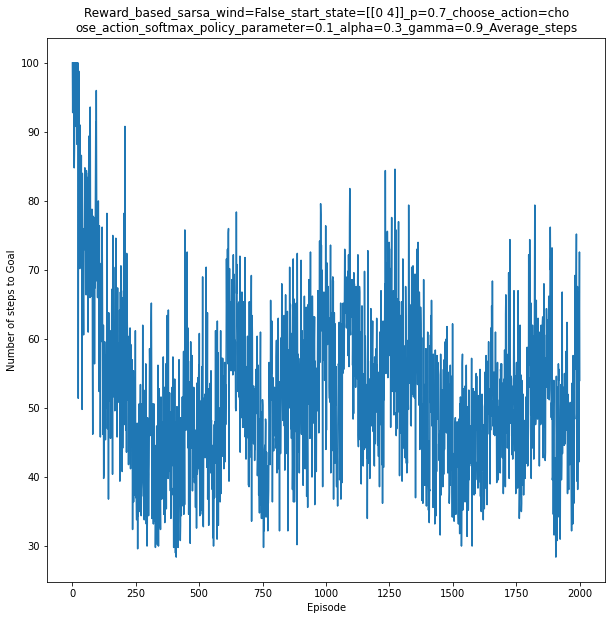

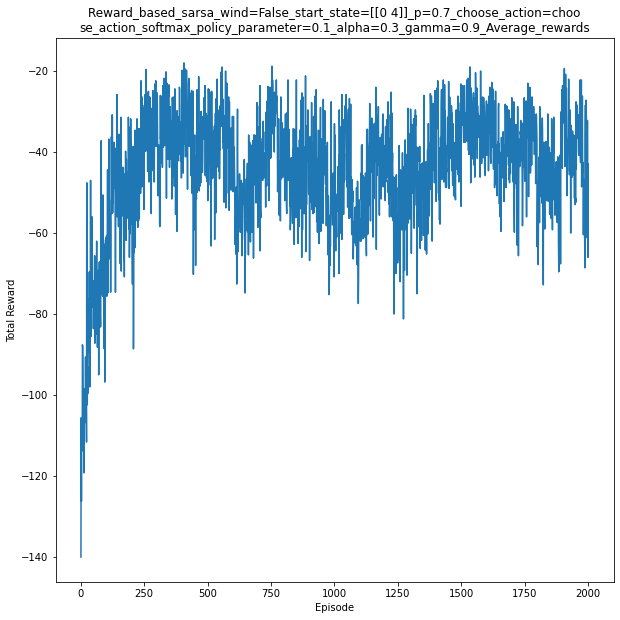

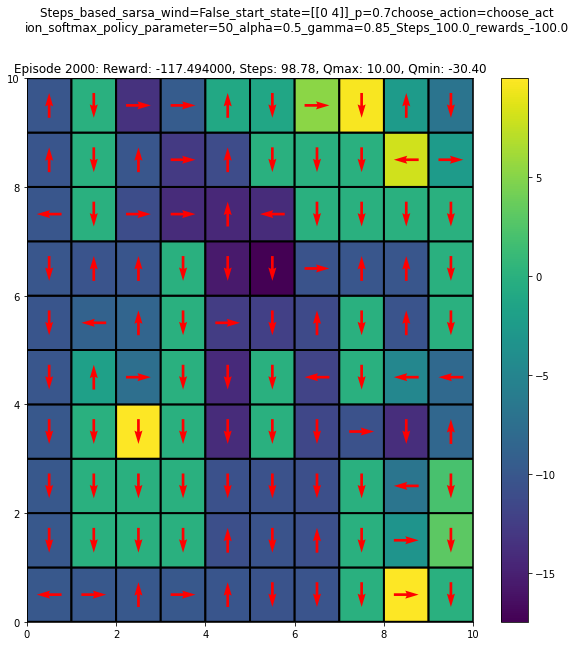

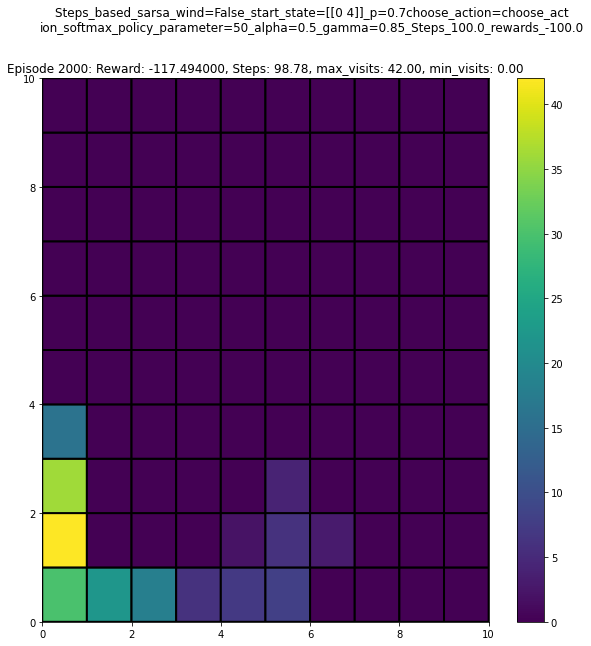

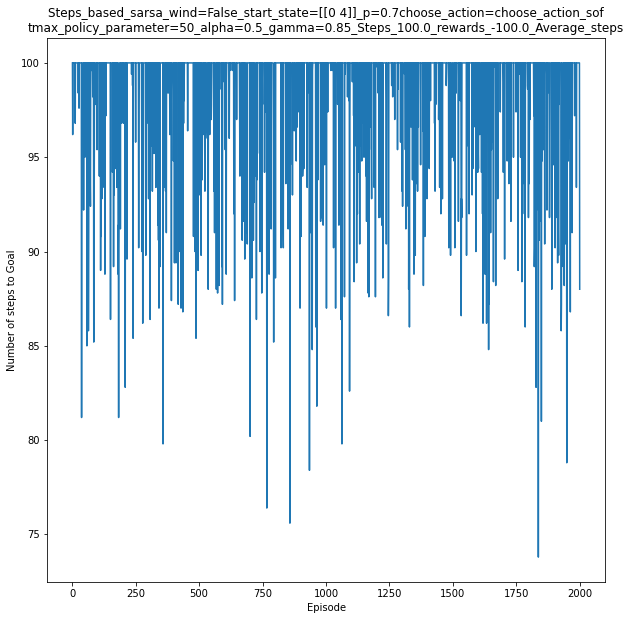

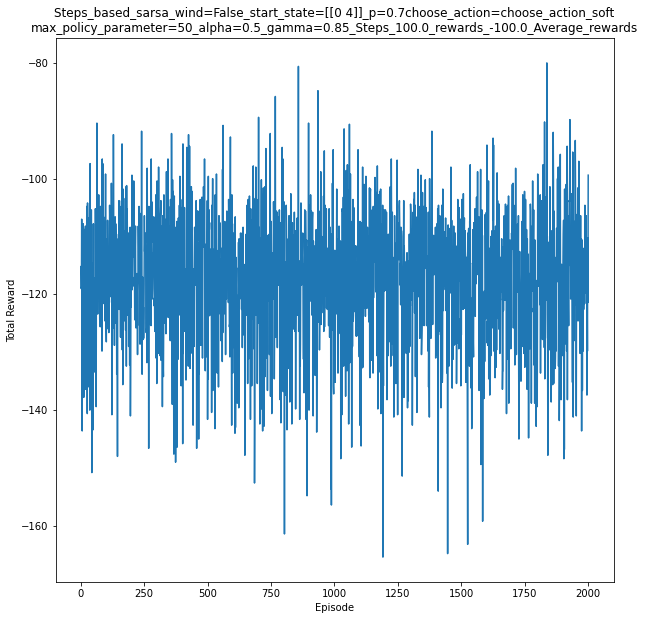

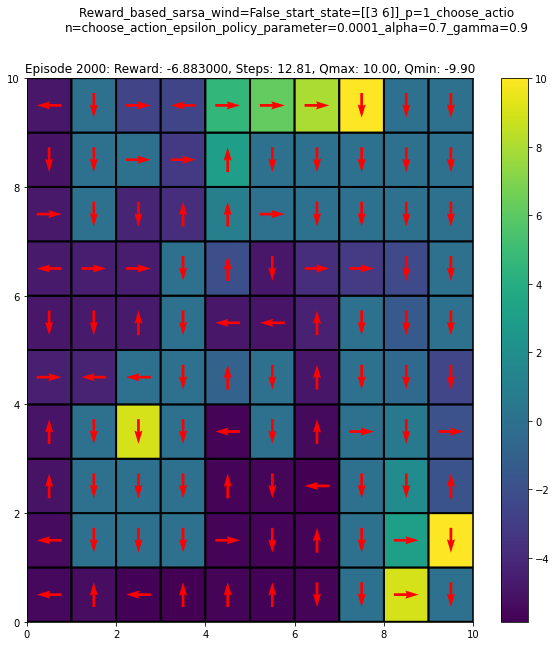

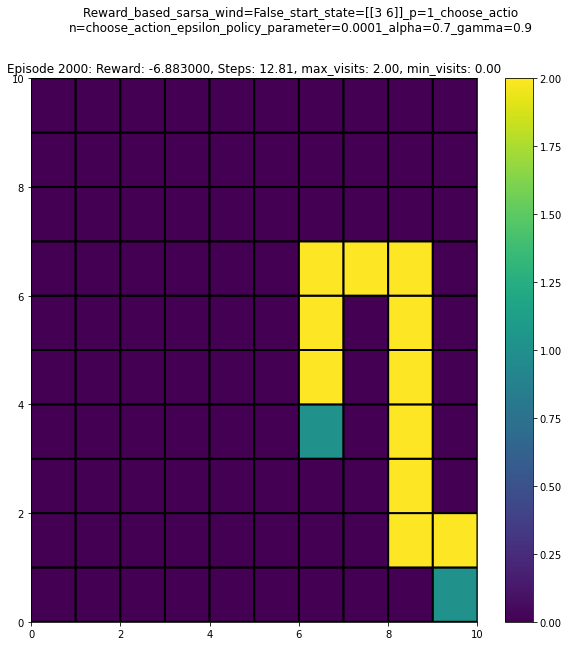

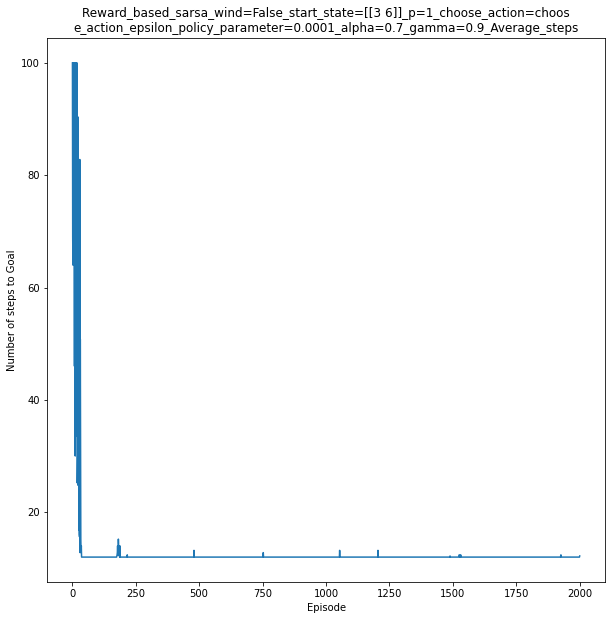

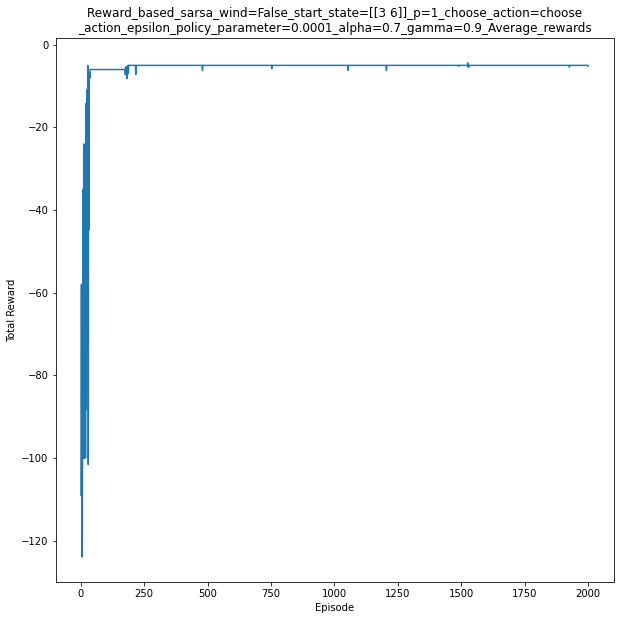

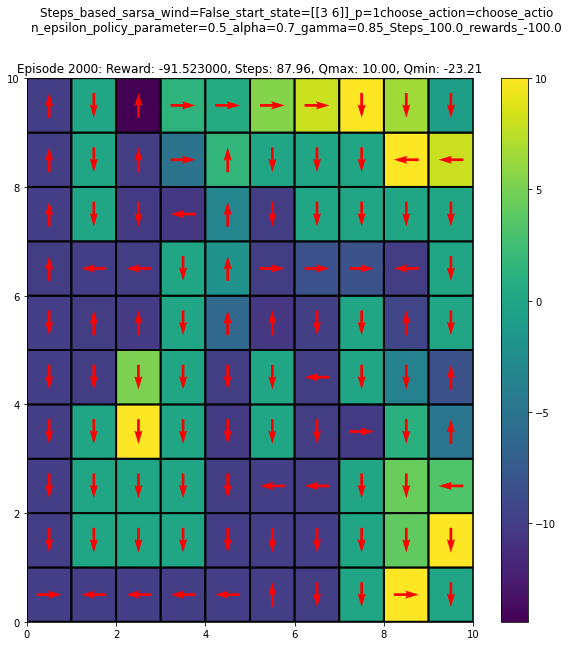

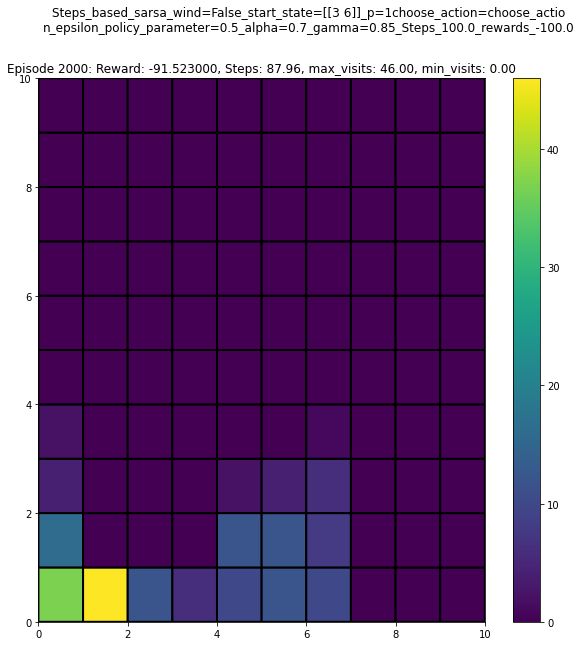

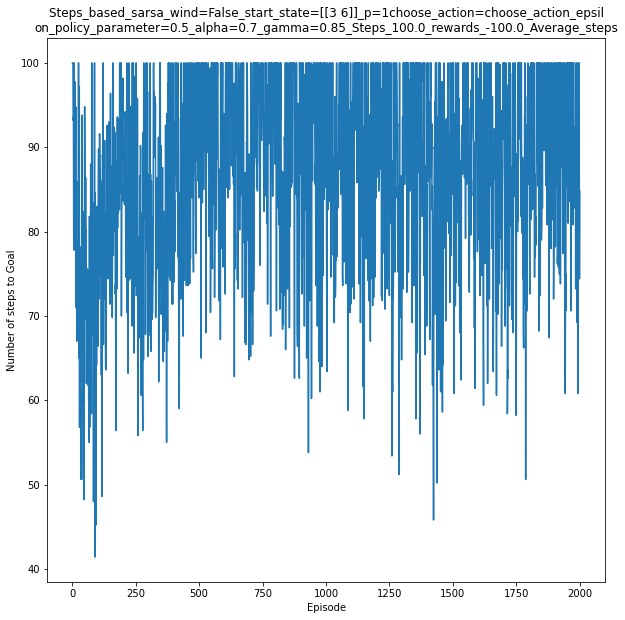

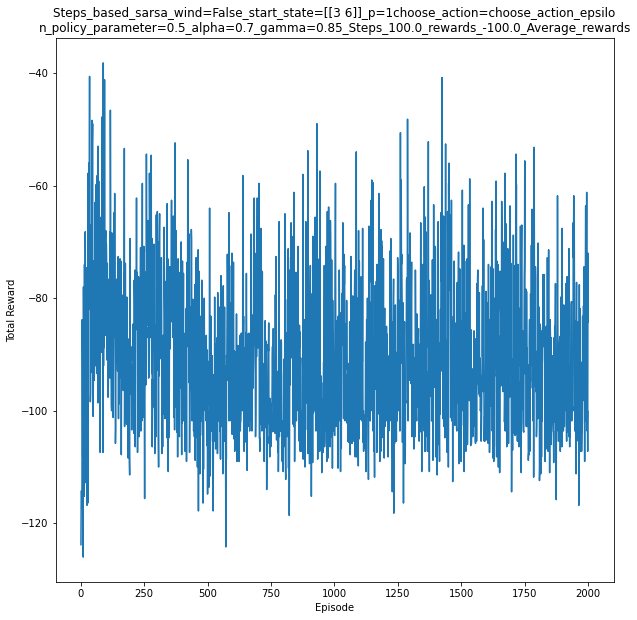

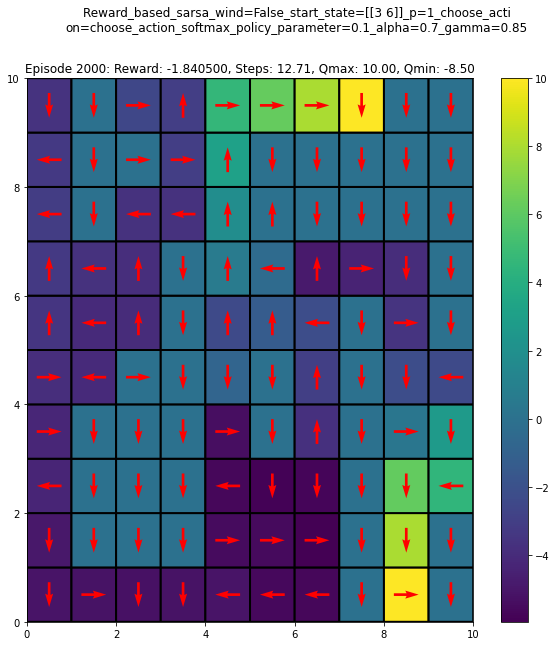

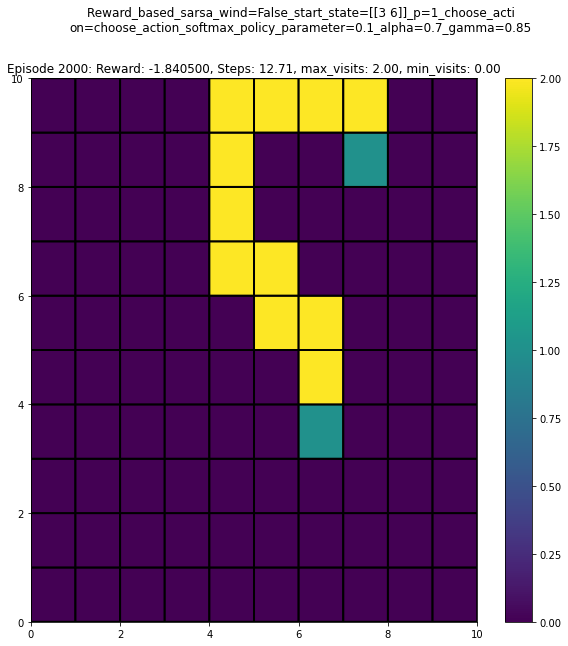

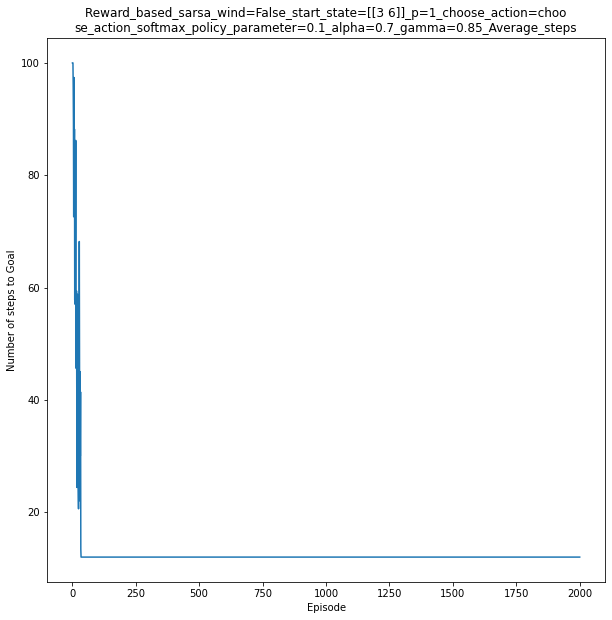

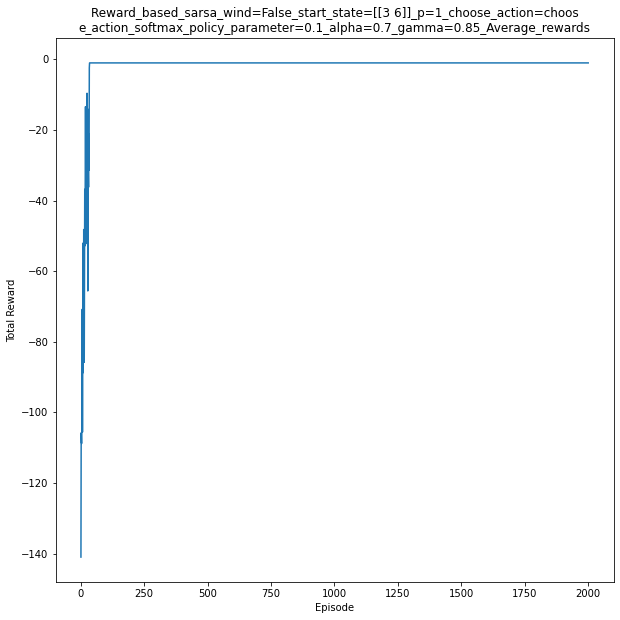

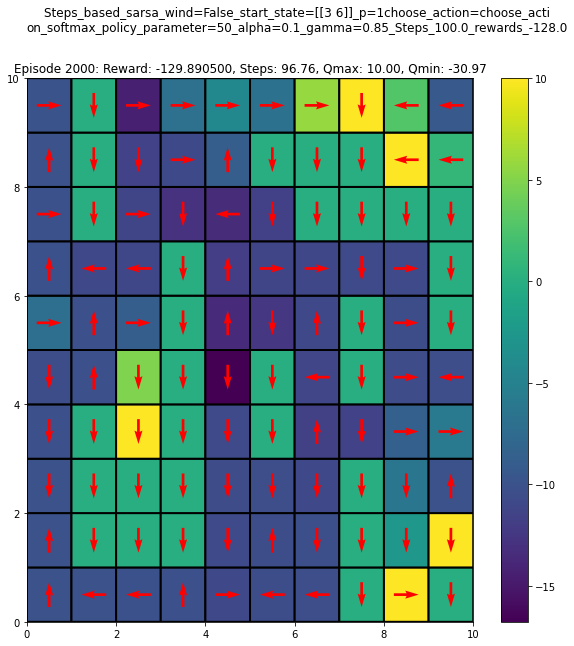

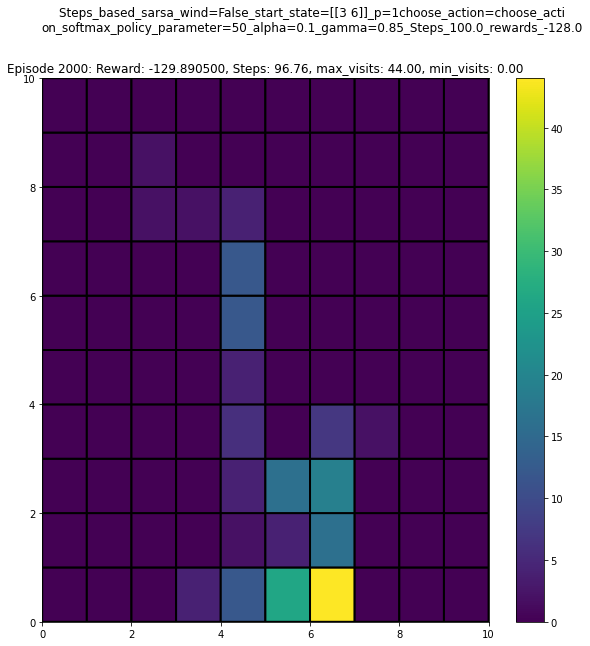

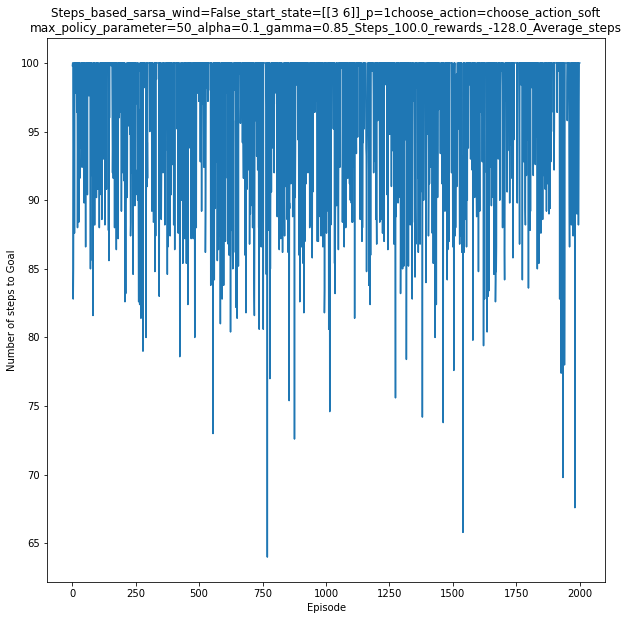

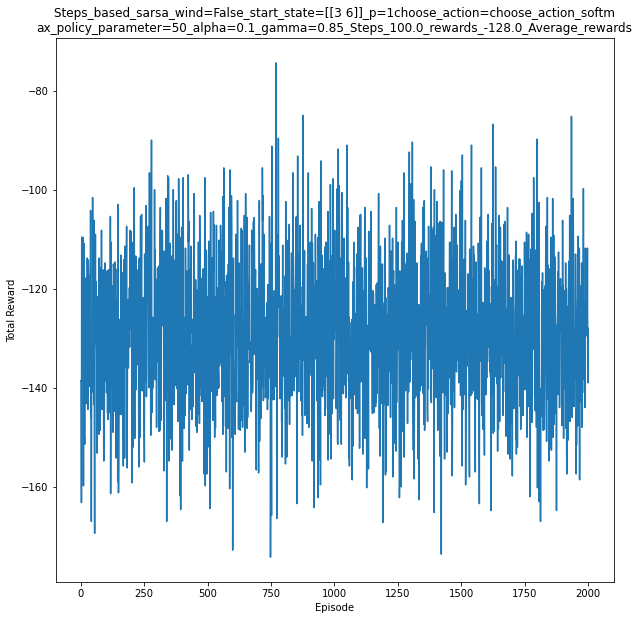

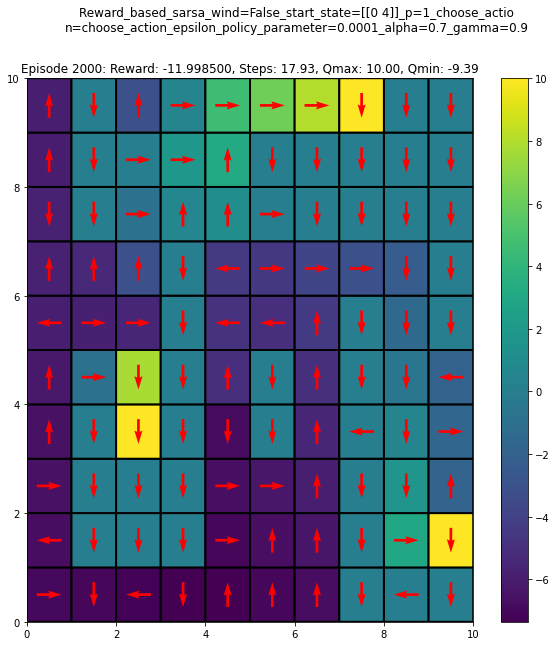

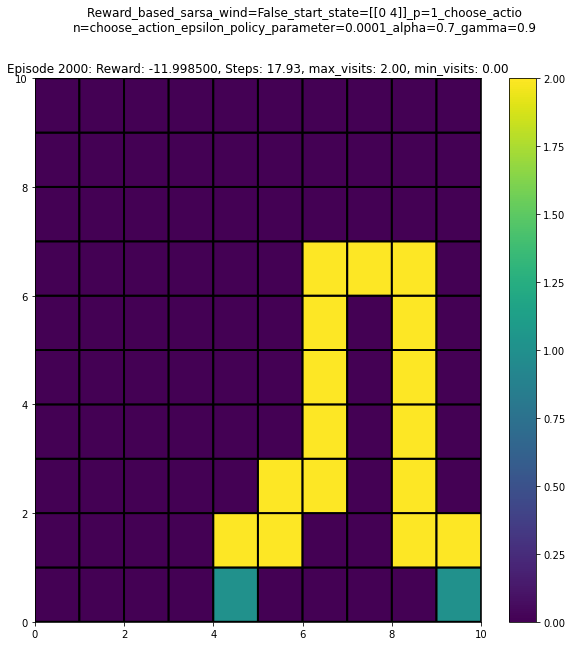

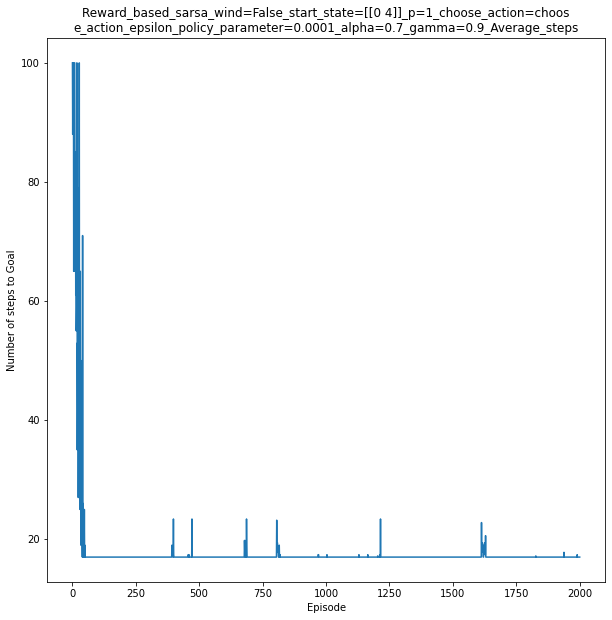

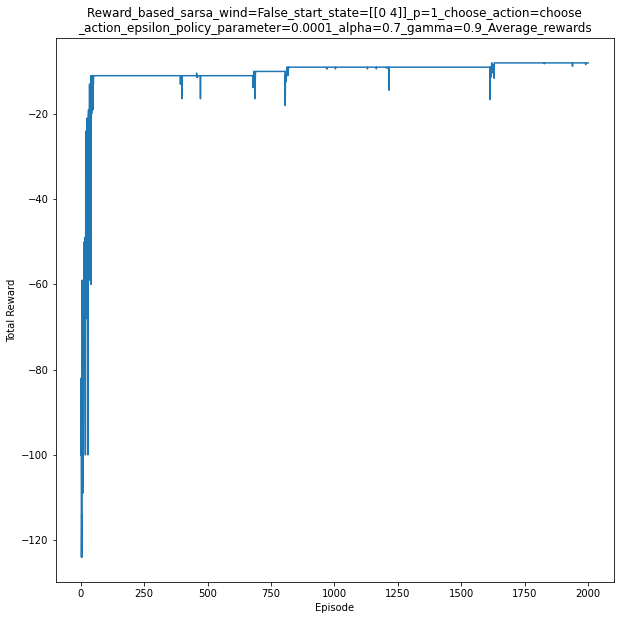

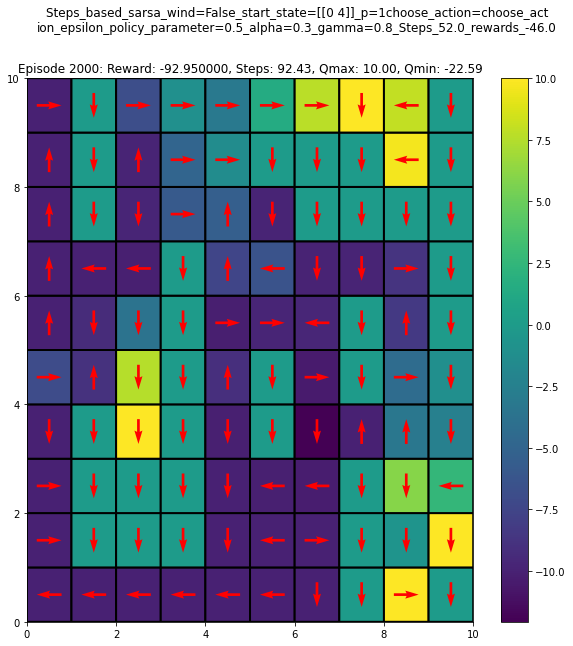

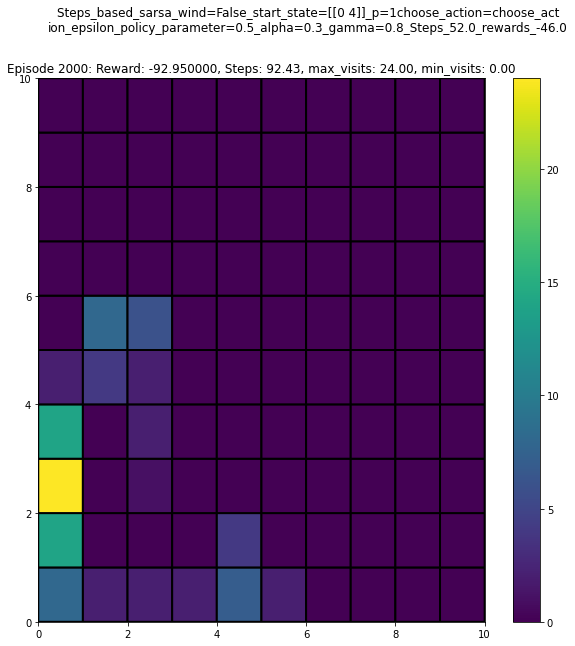

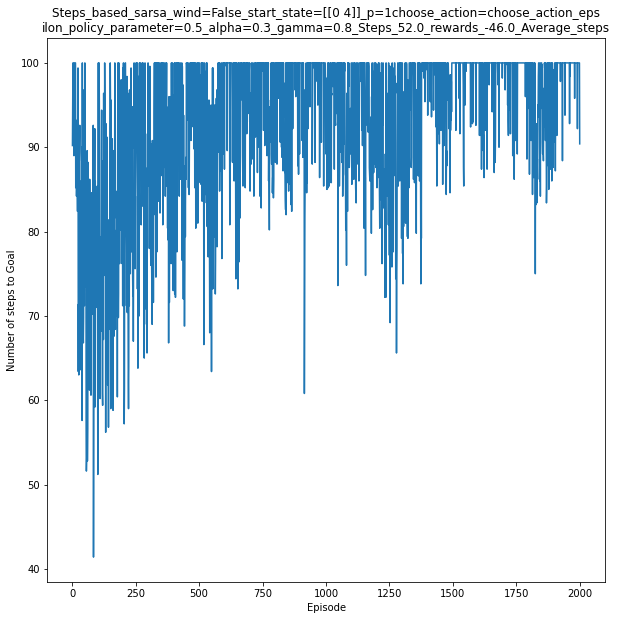

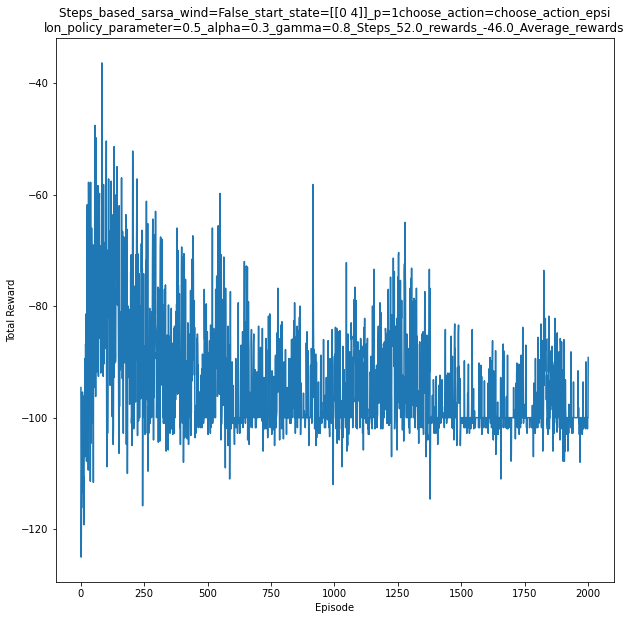

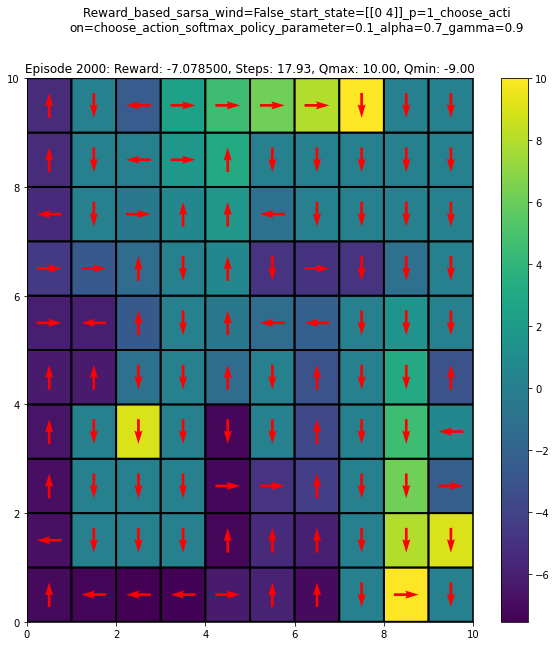

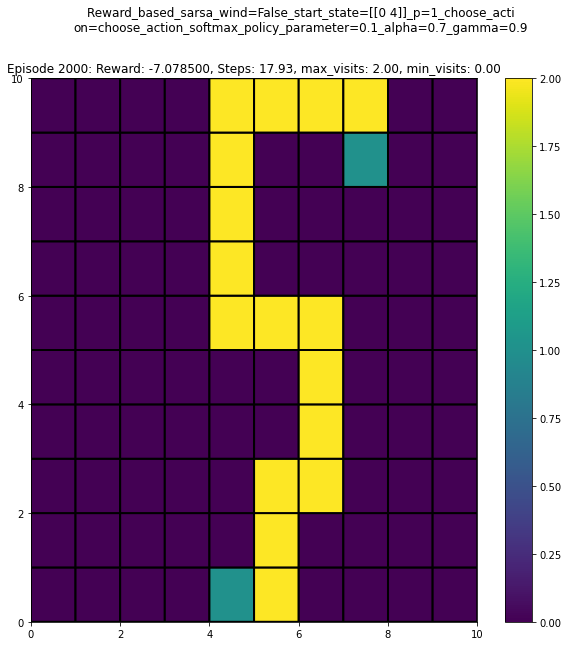

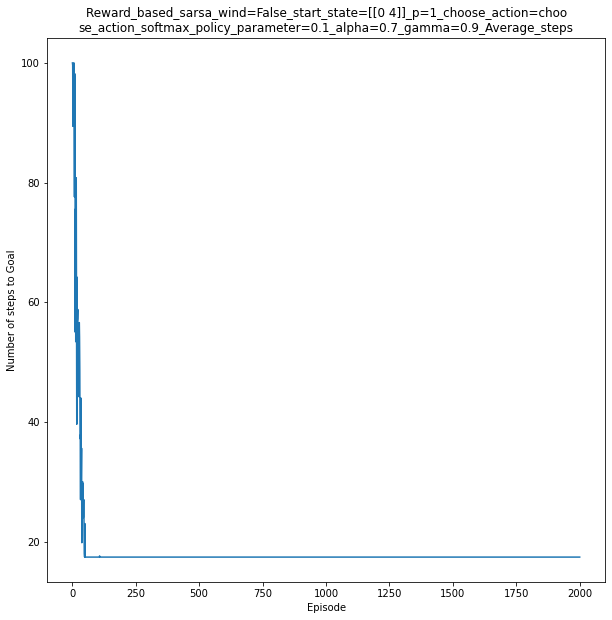

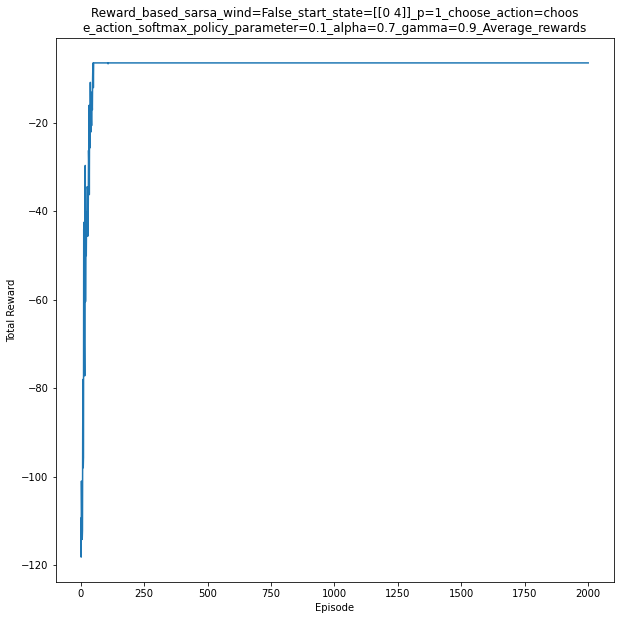

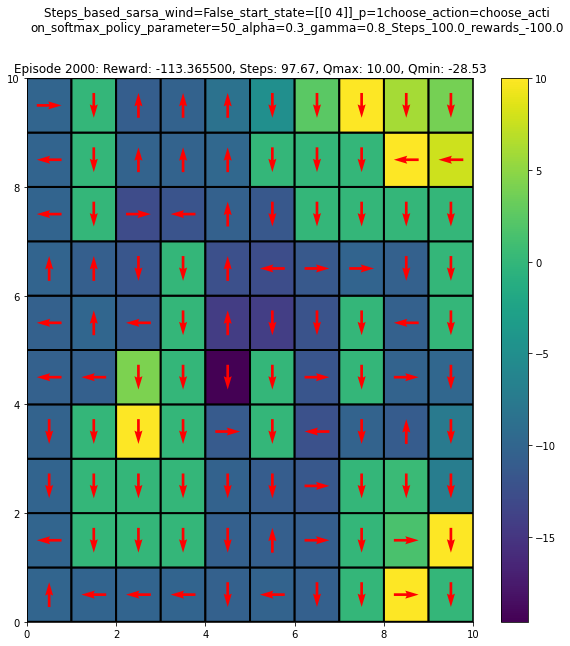

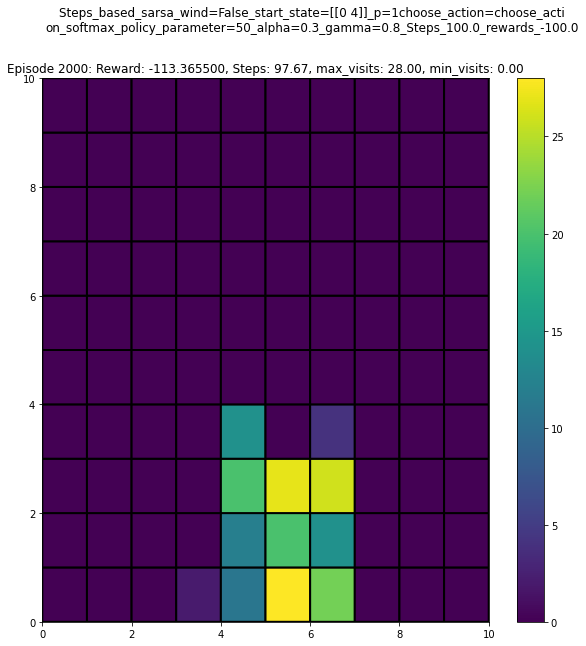

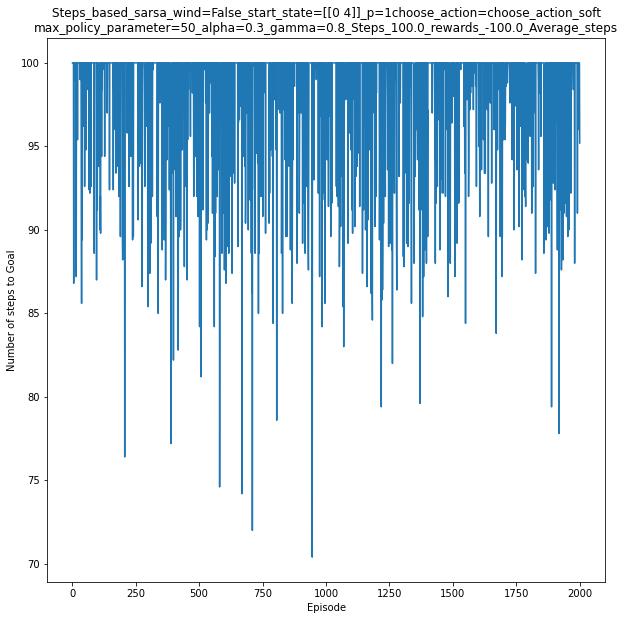

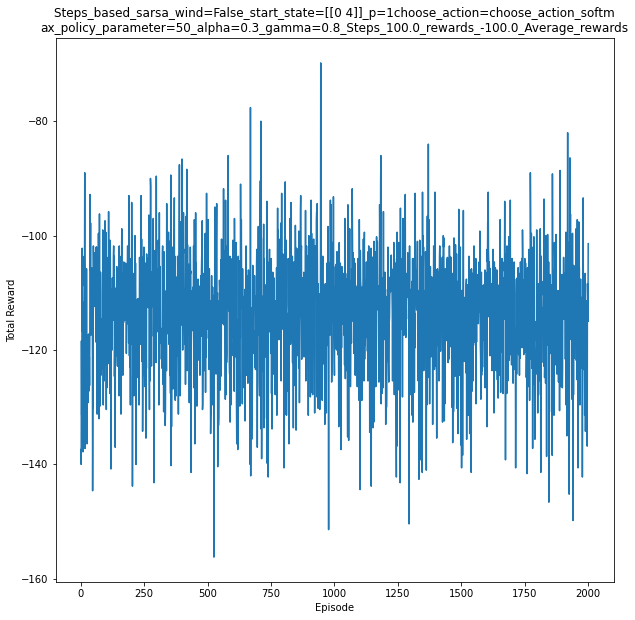

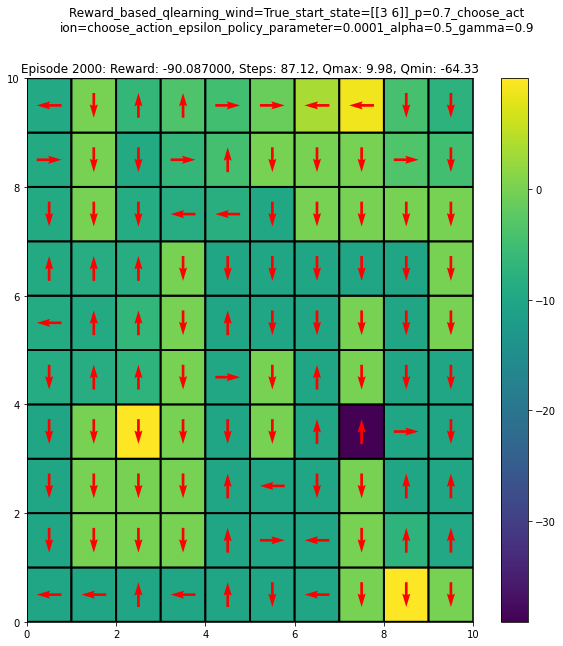

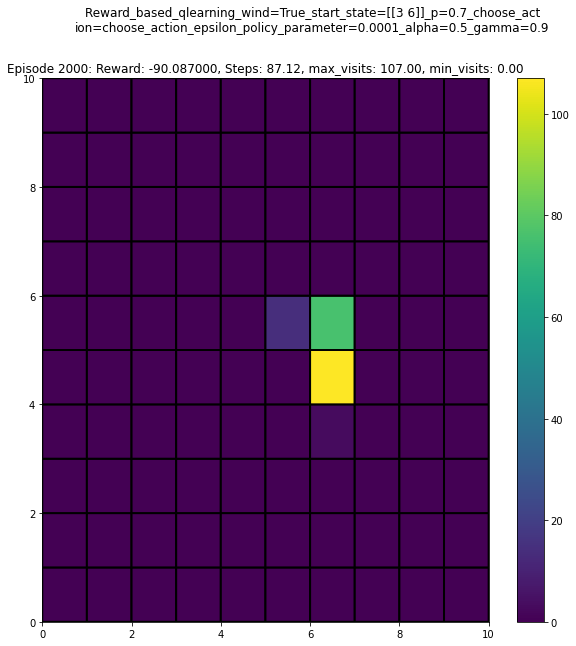

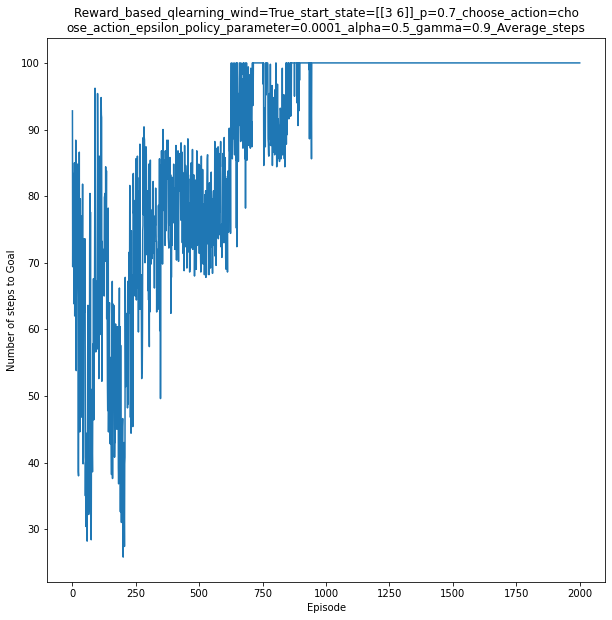

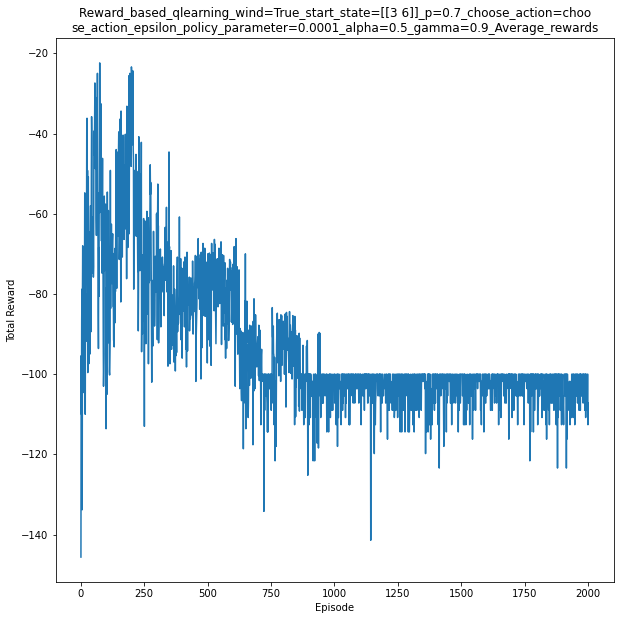

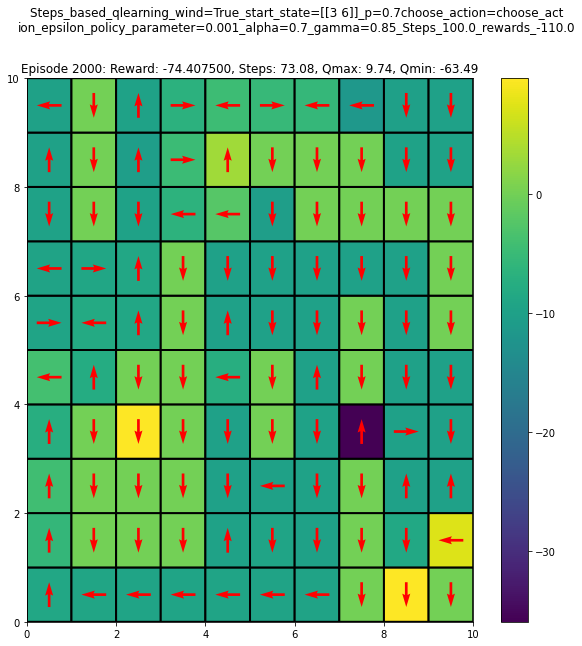

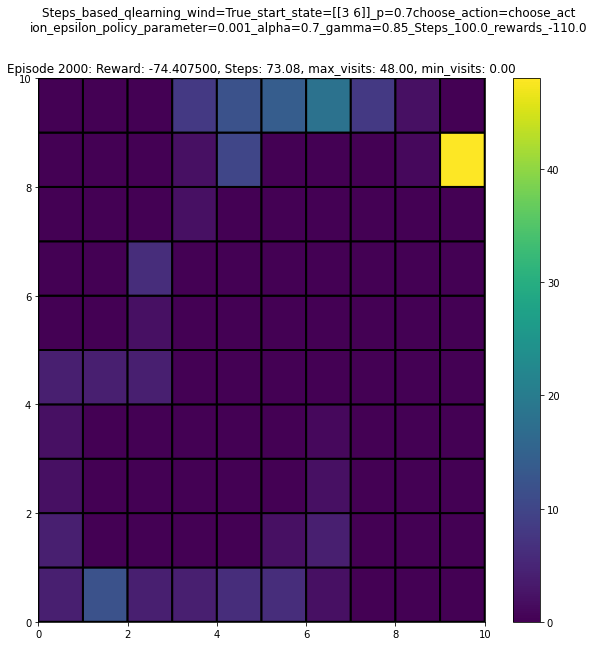

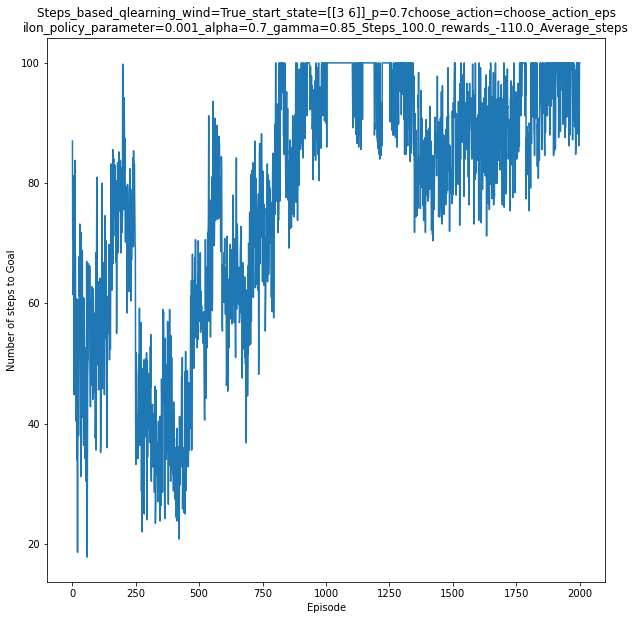

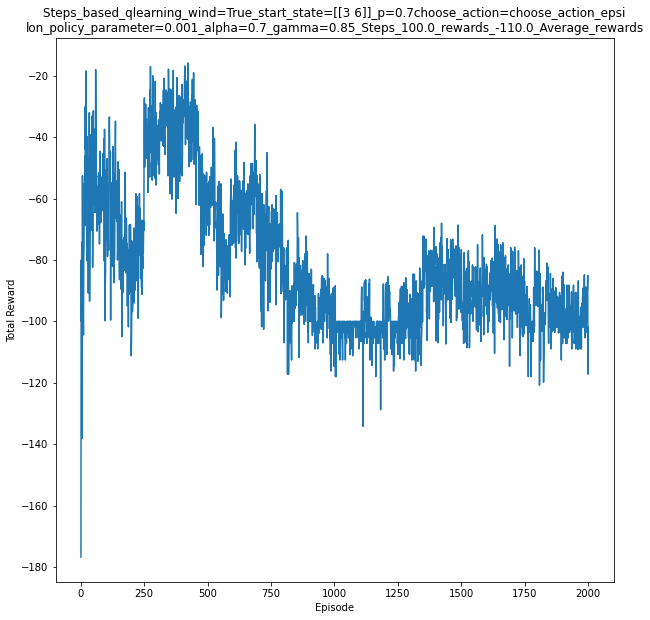

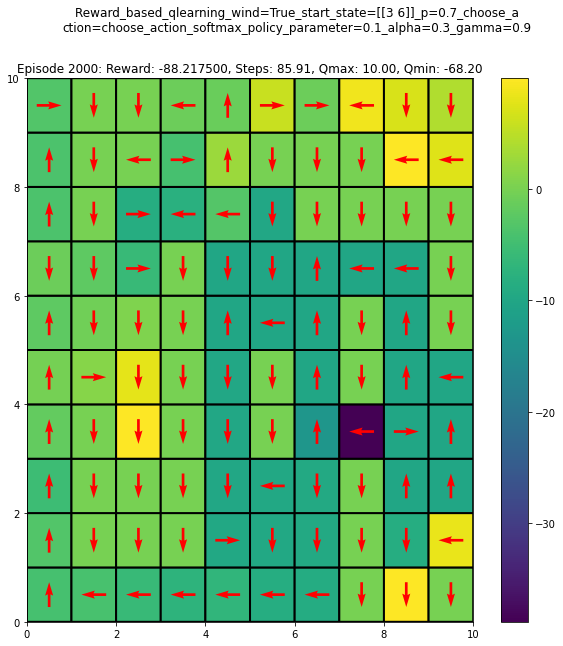

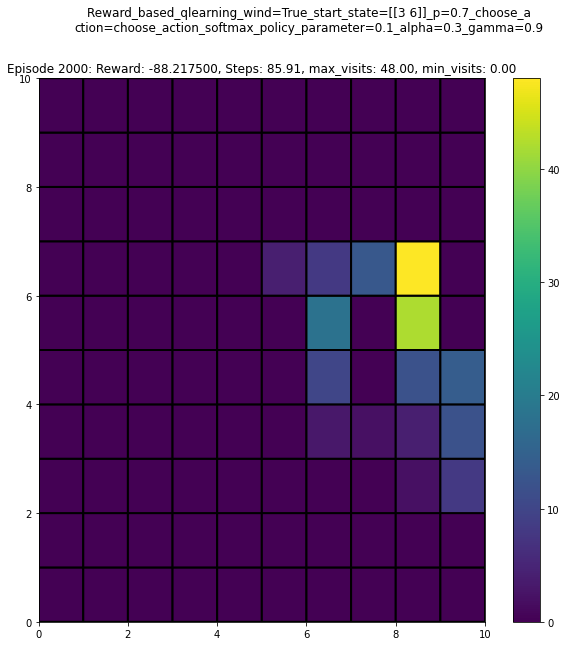

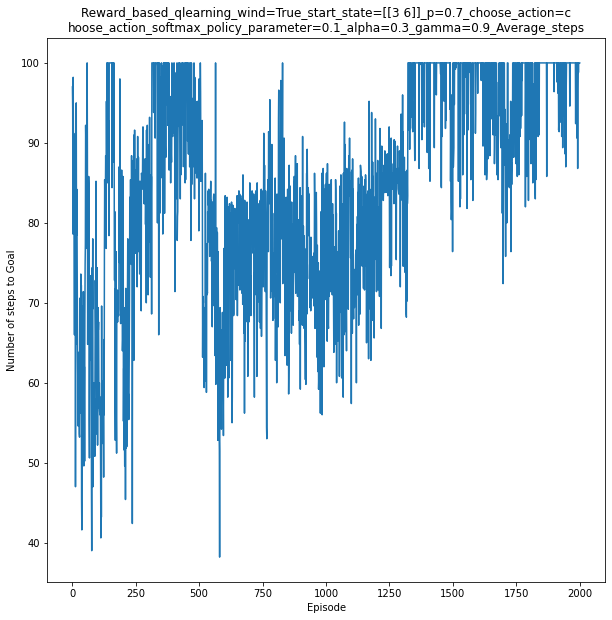

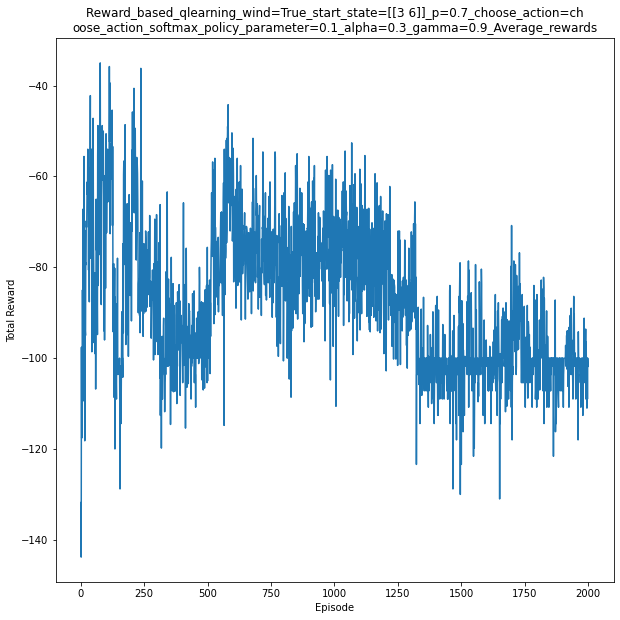

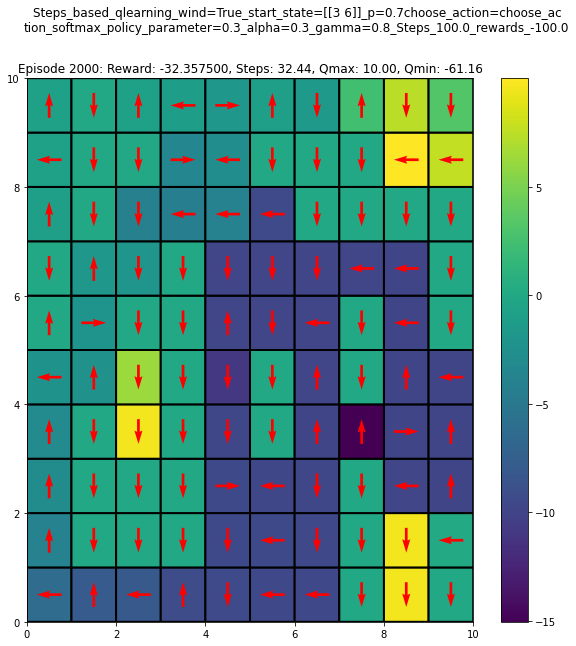

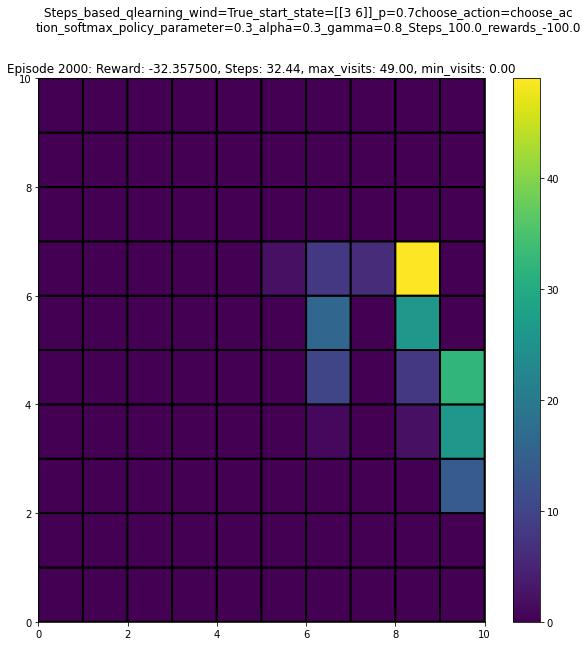

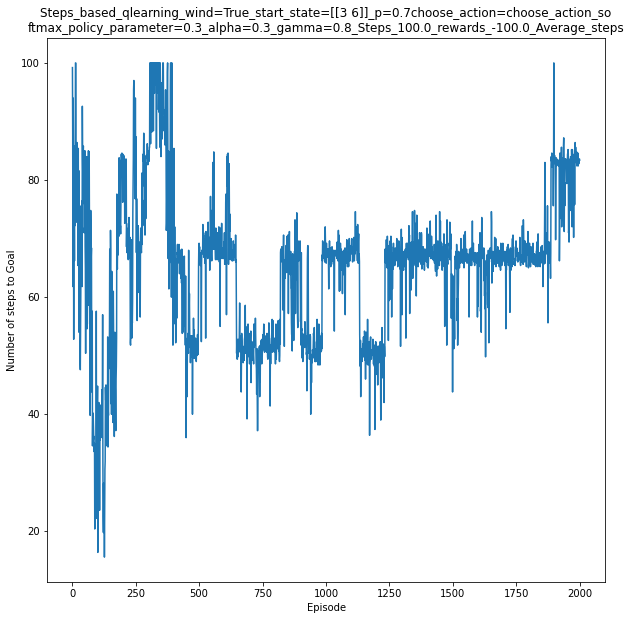

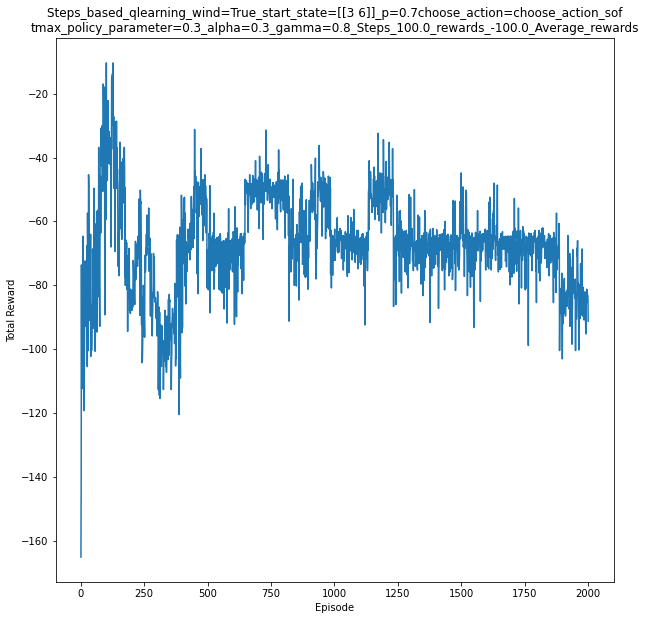

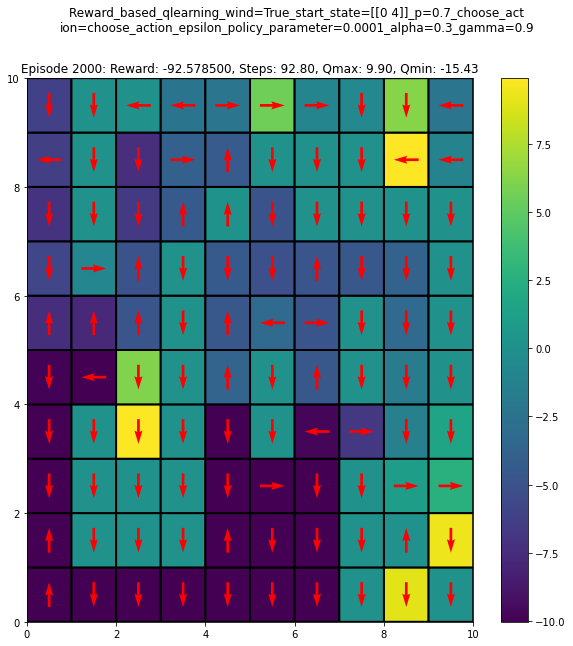

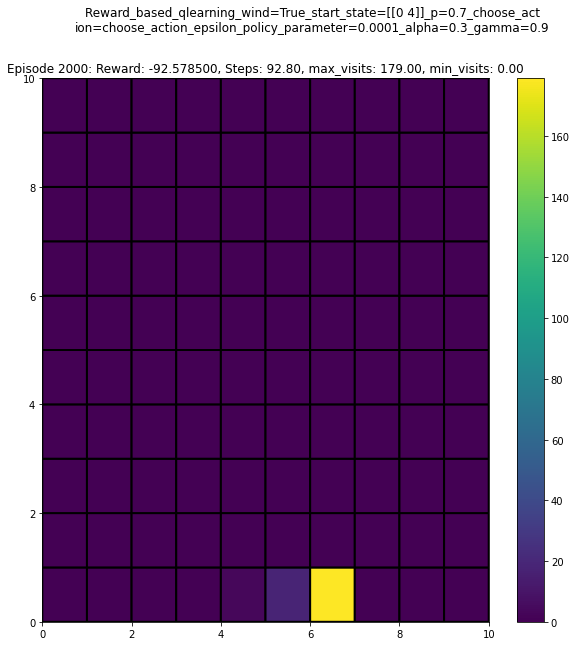

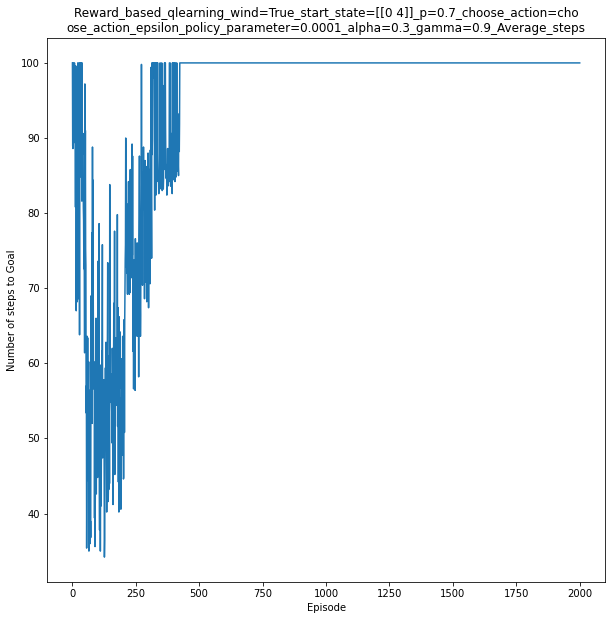

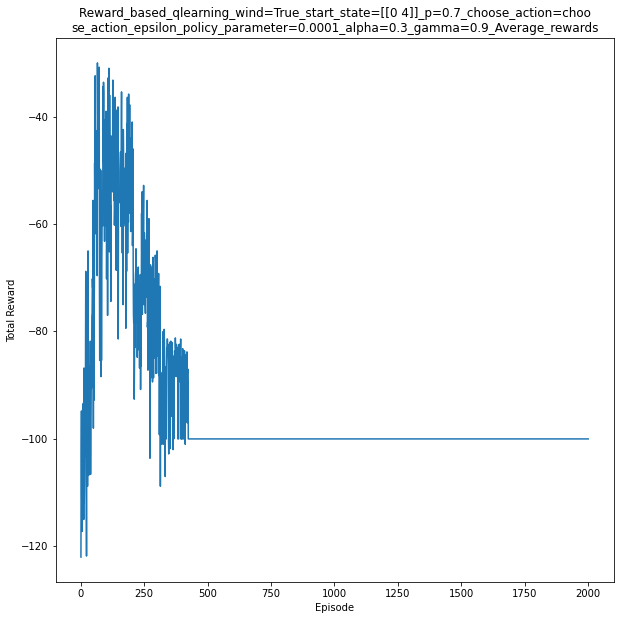

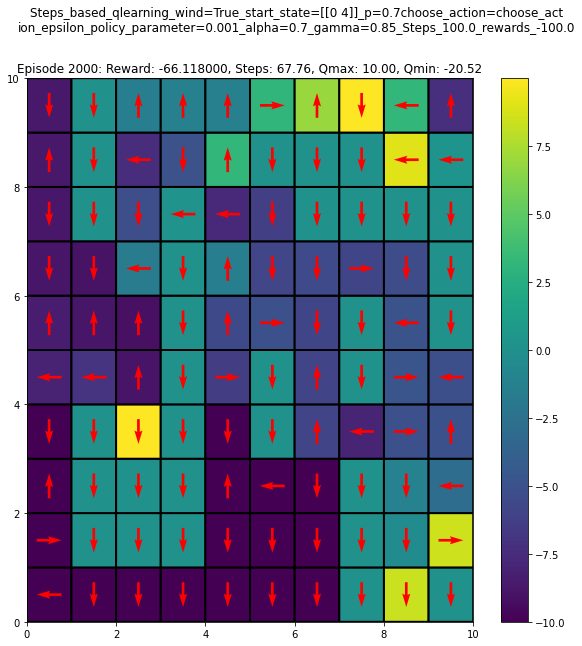

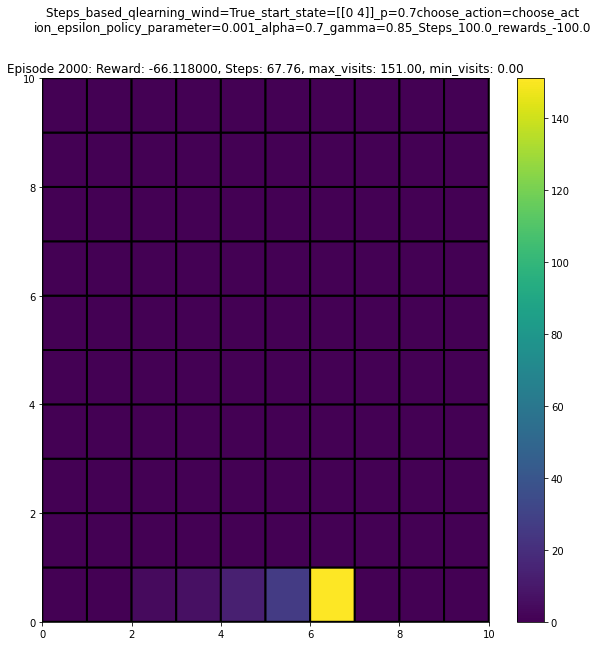

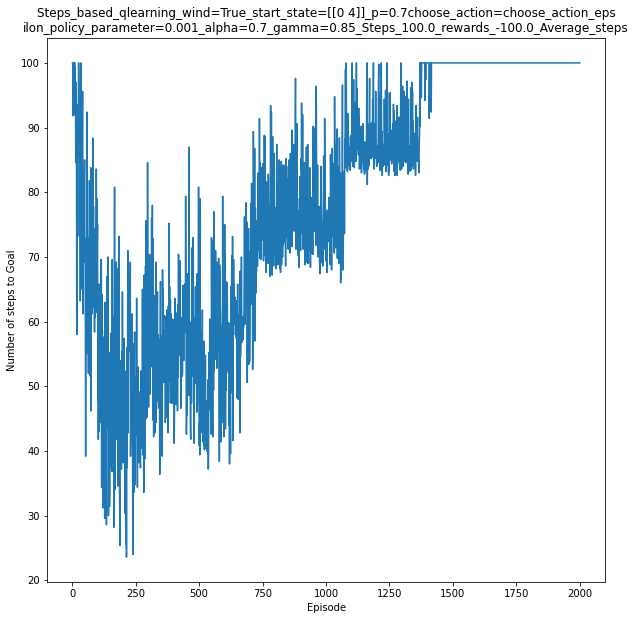

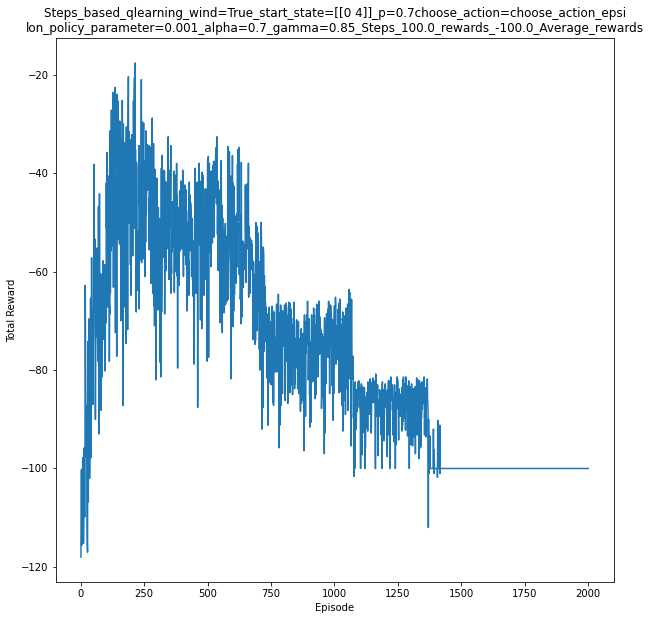

In [14]:
## Hyperparameters to be used in the experiments


epsilon_s=[0.1,0.7,0.001,0.5,0.05,0.9]
beta_s=[0.1,0.01,1,50,500,0.5]
alpha_s=[0.7,0.4,0.2,0.01,0.8,0.9]
gamma_s=[0.98,0.8,0.5,0.9,0.1,0.01]



wind_s=[True,False]
p_good_transition_s=[0.7,1]
start_state_s = [np.array([[3,6]]),np.array([[0,4]])]
choose_action_s=[choose_action_epsilon,choose_action_softmax]

algorithm_s=[sarsa,qlearning]
episodes = 2000


for algorithm in algorithm_s:
    for wind in wind_s:
        for p_good_transition in p_good_transition_s:
            for start_state in start_state_s:
                for choose_action in choose_action_s:


                    num_cols = 10
                    num_rows = 10
                    obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                                             [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                                             [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                                             [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
                    bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
                    restart_states = np.array([[3,7],[8,2]])

                    goal_states = np.array([[0,9],[2,2],[8,7]])

                    # create model
                    gw = GridWorld(num_rows=num_rows,
                                   num_cols=num_cols,
                                   start_state=start_state,
                                   goal_states=goal_states, wind = wind)
                    gw.add_obstructions(obstructed_states=obstructions,
                                        bad_states=bad_states,
                                        restart_states=restart_states)
                    gw.add_rewards(step_reward=-1,
                                   goal_reward=10,
                                   bad_state_reward=-6,
                                   restart_state_reward=-10)
                    gw.add_transition_probability(p_good_transition=p_good_transition,
                                                  bias=0.5)
                    env = gw.create_gridworld()
                    
                    if choose_action== choose_action_softmax:
                        action_softmax=True 
                    else:
                        action_softmax=False
                    best_config=Search_Grid(epsilon_s,beta_s,alpha_s,gamma_s,action_softmax=action_softmax)
                    
                    
                    
                    
                    
##Experiment config based on avg rewards
                    alpha,gamma,epsilon,beta=best_config["reward_based"]
                    if choose_action== choose_action_softmax:
                        choose_action_parameter=beta 
                    else:
                        choose_action_parameter=epsilon
                    num_expts = 5
                    reward_avgs, steps_avgs = [], []

                    for i in range(num_expts):
                        print("Experiment: %d"%(i+1))
                        Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
                        rg = np.random.RandomState(i)
                        Q, rewards, steps,state_visit_count = algorithm(env, Q, gamma , plot_heat=True, choose_action= choose_action,choose_action_parameter=choose_action_parameter)
                        steps_avgs.append(steps)
                        reward_avgs.append(rewards)
                    avg_rewards=(np.mean(reward_avgs,axis=0))
                    avg_steps=np.mean(steps_avgs,axis=0)
                    
                    
                    mess=f"Reward_based_{algorithm.__name__}_wind={wind}_start_state={start_state}_p={p_good_transition}_choose_action={choose_action.__name__}_policy_parameter={choose_action_parameter}_alpha={alpha}_gamma={gamma}"
                    file.write(mess+"\n")
                    prog_Q="Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(episodes, np.mean(rewards),
                                                                           np.mean(steps),
                                                                           Q.max(), Q.min())
                    prog_state_visits="Episode %d: Reward: %f, Steps: %.2f, max_visits: %.2f, min_visits: %.2f"%(episodes, np.mean(rewards),
                                                                           np.mean(steps),
                                                                           state_visit_count.max(), state_visit_count.min())
                    configs.append(mess)
                    plot_Q(Q,mess,prog_Q)
                    plot_state_visits(state_visit_count,mess,prog_state_visits)
                    plot_rewards_steps(avg_steps,avg_rewards,mess+"_Average_steps",mess+"_Average_rewards")
                    
                    
##Experiment config based on avg steps
                    alpha,gamma,epsilon,beta=best_config["steps_based"]
                    if choose_action== choose_action_softmax:
                        choose_action_parameter=beta 
                    else:
                        choose_action_parameter=epsilon
                    num_expts = 5
                    reward_avgs, steps_avgs = [], []

                    for i in range(num_expts):
                        print("Experiment: %d"%(i+1))
                        Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
                        rg = np.random.RandomState(i)
                        Q, rewards, steps,state_visit_count = algorithm(env, Q, gamma , plot_heat=True, choose_action= choose_action,choose_action_parameter=choose_action_parameter)
                        steps_avgs.append(steps)
                        reward_avgs.append(rewards)
                    avg_rewards=(np.mean(reward_avgs,axis=0))
                    avg_steps=np.mean(steps_avgs,axis=0)
                    
                    
                    mess=f"Steps_based_{algorithm.__name__}_wind={wind}_start_state={start_state}_p={p_good_transition}choose_action={choose_action.__name__}_policy_parameter={choose_action_parameter}_alpha={alpha}_gamma={gamma}_Steps_{steps[-1]}_rewards_{rewards[-1]}"
                    file.write(mess+"\n")
                    prog_Q="Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(episodes, np.mean(rewards),
                                                                           np.mean(steps),
                                                                           Q.max(), Q.min())
                    prog_state_visits="Episode %d: Reward: %f, Steps: %.2f, max_visits: %.2f, min_visits: %.2f"%(episodes, np.mean(rewards),
                                                                           np.mean(steps),
                                                                           state_visit_count.max(), state_visit_count.min())
                    configs.append(mess)
                    plot_Q(Q,mess,prog_Q)
                    plot_state_visits(state_visit_count,mess,prog_state_visits)
                    plot_rewards_steps(avg_steps,avg_rewards,mess+"_Average_steps",mess+"_Average_rewards")
                    
                
                
                
                
                
        
                
                
                
                
                
                
                
                
                
                
                
                
                
                